In [6]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import pandas as pd
from tqdm import tqdm
import numpy as np


In [45]:
def balanced_accuracy_vs_sim(directory):
    all_data = []
    
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            data = data["result"]
            for d in data:
                #d.pop('text')
                feature = filename.split(".txt")[0]
                d["feature"]=feature
            #remove from the data the points where predicted == -1
            data = [d for d in data if d["predicted"] != -1]
            
            all_data.extend(data)
    
    data_df = pd.DataFrame(all_data)
    data_df["correct"]=data_df["ground_truth"]==data_df["predicted"]
    #reverse the quantiles, -1 stays the same but the rest are reversed
    unique_quantiles= len(data_df["quantile"].unique())-2
    data_df["quantile"]=data_df["quantile"].apply(lambda x: x if x == -1 else unique_quantiles-x)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]

    features = detector["feature"].unique()
    detector_scores = {}
    fuzzing_scores = {}
    for i in features:
        individual_scores = detector[detector["feature"]==i]
        detector_scores[i]=calculate_balanced_accuracy(individual_scores)
        individual_scores = fuzzing[fuzzing["feature"]==i]
        fuzzing_scores[i] = calculate_balanced_accuracy(individual_scores)

    return detector_scores, fuzzing_scores

In [37]:
def accuracy_vs_sim(directory):
    all_data = []
    
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            data = data["result"]
            for d in data:
                #d.pop('text')
                feature = filename.split(".txt")[0]
                d["feature"]=feature
            #remove from the data the points where predicted == -1
            data = [d for d in data if d["predicted"] != -1]
            
            all_data.extend(data)
    
    data_df = pd.DataFrame(all_data)
    data_df["correct"]=data_df["ground_truth"]==data_df["predicted"]
    #reverse the quantiles, -1 stays the same but the rest are reversed
    unique_quantiles= len(data_df["quantile"].unique())-2
    data_df["quantile"]=data_df["quantile"].apply(lambda x: x if x == -1 else unique_quantiles-x)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]

    features = detector["feature"].unique()
    detector_scores = {}
    fuzzing_scores = {}
    for i in features:
        individual_scores = detector[detector["feature"]==i]
        #top_quantile = individual_scores[individual_scores["quantile"]<8]
        #top_quantile = top_quantile[top_quantile["quantile"]>0]
        detector_scores[i]= calculate_accuracy(individual_scores)
        individual_scores = fuzzing[fuzzing["feature"]==i]
        #top_quantile = individual_scores[individual_scores["quantile"]<8]
        #top_quantile = top_quantile[top_quantile["quantile"]>0]
        fuzzing_scores[i] = calculate_accuracy(individual_scores)

    return detector_scores, fuzzing_scores

In [3]:
def score_prfa(dataframe,inverse=False):
    #True positive when data["activates"]==True and data["marked"]==True
    #False positive when data["activates"]==True and data["marked"]==False
    #True negative when data["activates"]==False and data["marked"]==False
    #False negative when data["activates"]==False and data["marked"]==True

    tp = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==True)])
    fp = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==True)])
    tn = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==False)])
    fn = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==False)])
    if inverse:
        tp,fp,tn,fn = tn,fn,tp,fp
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    if precision+recall == 0:
        f1 = 0
    else:
        f1 = 2*(precision*recall)/(precision+recall)
    if tn+fp == 0:
        balanced_accuracy = 0
    else:
        balanced_accuracy = (recall+tn/(tn+fp))/2
    return precision, recall, f1, balanced_accuracy

In [4]:

def estimate_errorbars_right(dataframe, num_iterations=10):
    scores = []
    
    for _ in range(num_iterations):
        # Sample the data with replacement
        data = dataframe.sample(frac=0.2, replace=True)
        # Call score_right with the shuffled data
        score = score_right(data)
        scores.append(score)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    return mean_score, std_score

In [5]:
def score_right(dataframe):
    tp = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==True)])
    tn = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==False)])
    right = tp+tn
    if len(dataframe) == 0:
        return 0
    return right/len(dataframe) , 

In [6]:
def analyse(directory,number_files=1000):
    all_data = []
    counter = 0
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            data = data["result"]
            for d in data:
                #d.pop('text')
                feature = filename.split("feature")[-1][:-4]
                d["feature"]=feature
            #remove from the data the points where predicted == -1
            data = [d for d in data if d["predicted"] != -1]
            
            all_data.extend(data)
            if counter >= number_files:
                break
            counter += 1
    if len(all_data) == 0:
        return None, None, None, None, None
    data_df = pd.DataFrame(all_data)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]
    per_quantile_agregate_detector = []
    per_quantile_agregate_fuzzing = []
    
    #per_quantile_agregate_detector.append(estimate_errorbars_right(detector))
    #per_quantile_agregate_fuzzing.append(estimate_errorbars_right(fuzzing))
    unique_quantiles = detector["quantile"].unique()

    quantile = detector[detector["quantile"]==-1]
    per_quantile_agregate_detector.append(estimate_errorbars_right(quantile))
    
    quantile = fuzzing[fuzzing["quantile"]==-1]
    per_quantile_agregate_fuzzing.append(estimate_errorbars_right(quantile))

    for q in range(len(unique_quantiles)-2,-1,-1):
        quantile = detector[detector["quantile"]==q]
        per_quantile_agregate_detector.append(estimate_errorbars_right(quantile))
        
        quantile = fuzzing[fuzzing["quantile"]==q]
        per_quantile_agregate_fuzzing.append(estimate_errorbars_right(quantile))
        
    individual_detector = {"precision":[],"recall":[],"f1":[], "balanced_accuracy":[]}
    individual_fuzzing = {"precision":[],"recall":[],"f1":[], "balanced_accuracy":[]}
    features = detector["feature"].unique()
    for i in features:
        individual_scores = detector[detector["feature"]==i]
        precision, recall, f1,balanced_accuracy = score_prfa(individual_scores)
        individual_detector["precision"].append(precision)
        individual_detector["recall"].append(recall)
        individual_detector["f1"].append(f1)
        individual_detector["balanced_accuracy"].append(balanced_accuracy)

        individual_scores = fuzzing[fuzzing["feature"]==i]
        precision, recall, f1,balanced_accuracy = score_prfa(individual_scores)
        individual_fuzzing["precision"].append(precision)
        individual_fuzzing["recall"].append(recall)
        individual_fuzzing["f1"].append(f1)
        individual_fuzzing["balanced_accuracy"].append(balanced_accuracy)
    
    return np.array(per_quantile_agregate_detector), np.array(per_quantile_agregate_fuzzing), individual_detector, individual_fuzzing, data_df

    


    

In [8]:
cd /mnt/ssd-1/gpaulo/SAE-Zoology

/mnt/ssd-1/gpaulo/SAE-Zoology


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
def quantiles_accuracy(directory,number_files=1000):
    all_data = []
    counter = 0
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            data = data["result"]
            for d in data:
                #d.pop('text')
                feature = filename.split("feature")[-1][:-4]
                d["feature"]=feature
            #remove from the data the points where predicted == -1
            data = [d for d in data if d["predicted"] != -1]
            
            all_data.extend(data)
            if counter >= number_files:
                break
            counter += 1
    if len(all_data) == 0:
        return None, None, None, None, None
    data_df = pd.DataFrame(all_data)
    data_df["correct"]=data_df["ground_truth"]==data_df["predicted"]
    #reverse the quantiles, -1 stays the same but the rest are reversed
    unique_quantiles= len(data_df["quantile"].unique())-2
    data_df["quantile"]=data_df["quantile"].apply(lambda x: x if x == -1 else unique_quantiles-x)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]
    return detector, fuzzing

    


    

In [9]:
def right_per_quantile(filenames,labels,name,both=False,errorbars=False):
    if both:
        fig, axs = plt.subplots(1, 2,figsize=(10,5))
    else:
        fig, axs = plt.subplots(1, 1,figsize=(5,5))
   
    x = None
    quantiles = None
    for i,filename in enumerate(filenames):
        detector, fuzzing = quantiles_accuracy("scores/"+filename)
        if x is None:
            x = sorted(detector["quantile"].unique())
            quantiles = ["Non activating"]
            quantiles.extend([f"Q{i+1}" for i in range(len(x)-1)])
            #quantiles += [" "]
            #quantiles += ["Most activating"]
            colors = sns.color_palette("tab10", len(x))
        if both:
            sns.lineplot(fuzzing,x="quantile",y="correct",label=labels[i],color=colors[i],ax=axs[1])
            sns.lineplot(detector,x="quantile",y="correct",label=labels[i],color=colors[i],ax=axs[0])
        else:
            sns.lineplot(detector,x="quantile",y="correct",label=labels[i],color=colors[i],ax=axs)
    if both:
        axs[0].set_ylabel("Fraction of right predictions")
        axs[0].set_title("Detection")
        axs[0].set_xlabel("Density quantile")
        axs[0].legend()
        axs[0].set_xticks(x,quantiles,rotation=60)
        axs[1].set_title("Fuzzing")
        axs[1].set_xlabel("Density quantile")
        axs[1].set_ylabel("")
        
        axs[1].legend()
        axs[1].set_xticks(x,quantiles,rotation=60)
        
        axs[1].set_xticklabels(quantiles)
        axs[1].set_ylim(0.1,1)
        axs[0].set_ylim(0.1,1)
    else:
        axs.set_ylabel("Fraction of right predictions")
        axs.set_title("Right predictions per quantile")
        axs.set_xlabel("Density quantile")
        axs.legend()
        axs.set_xticks(x,quantiles,rotation=60)
        axs.set_ylim(0.1,1)
    plt.savefig(f"right_per_quantile-{name}.svg")
   

In [10]:
def calculate_accuracy(dataframe):
    #True positive when data["activates"]==True and data["marked"]==True
    #False positive when data["activates"]==True and data["marked"]==False
    #True negative when data["activates"]==False and data["marked"]==False
    #False negative when data["activates"]==False and data["marked"]==True

    tp = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==True)])
    tn = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==False)])
    accuracy = (tp+tn)/len(dataframe)
    return accuracy

In [44]:
def calculate_balanced_accuracy(dataframe):
    #True positive when data["activates"]==True and data["marked"]==True
    #False positive when data["activates"]==True and data["marked"]==False
    #True negative when data["activates"]==False and data["marked"]==False
    #False negative when data["activates"]==False and data["marked"]==True

    tp = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==True)])
    fp = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==True)])
    tn = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["predicted"]==False)])
    fn = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["predicted"]==False)])
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    if tn+fp == 0:
        balanced_accuracy = 0
    else:
        balanced_accuracy = (recall+tn/(tn+fp))/2
    return balanced_accuracy

In [11]:
def feature_accuracy(directory,number_files=1000):
    all_data = []
    counter = 0
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            data = data["result"]
            for d in data:
                #d.pop('text')
                feature = filename.split(".txt")[0]
                d["feature"]=feature
            #remove from the data the points where predicted == -1
            data = [d for d in data if d["predicted"] != -1]
            
            all_data.extend(data)
            if counter >= number_files:
                break
            counter += 1
    if len(all_data) == 0:
        return None, None, None, None, None
    data_df = pd.DataFrame(all_data)
    data_df["correct"]=data_df["ground_truth"]==data_df["predicted"]
    #reverse the quantiles, -1 stays the same but the rest are reversed
    unique_quantiles= len(data_df["quantile"].unique())-2
    data_df["quantile"]=data_df["quantile"].apply(lambda x: x if x == -1 else unique_quantiles-x)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]

    features = detector["feature"].unique()
    detector_scores = {}
    fuzzing_scores = {}
    for i in features:
        individual_scores = detector[detector["feature"]==i]
        detector_scores[i]=calculate_balanced_accuracy(individual_scores)
        individual_scores = fuzzing[fuzzing["feature"]==i]
        fuzzing_scores[i] = calculate_balanced_accuracy(individual_scores)
    return detector_scores, fuzzing_scores

In [12]:
def accuracy_distribution(filenames,labels,both=False,kde=False):
    if both:
        fig, axs = plt.subplots(1, 2,figsize=(10,5))
    else:
        fig, axs = plt.subplots(1, 1,figsize=(5,5))
    for i,filename in enumerate(filenames):
        detector, fuzzing = feature_accuracy("scores/"+filename)
        if kde:
            if both:
                sns.kdeplot(fuzzing, label=labels[i],ax=axs[1])
                sns.kdeplot(detector, label=labels[i],ax=axs[0])
            else:
                sns.kdeplot(detector, label=labels[i],ax=axs)
        else:
            if both:
                sns.histplot(fuzzing, label=labels[i],stat="density",ax=axs[1])
                sns.histplot(detector, label=labels[i],stat="density",ax=axs[0])
            else:
                sns.histplot(detector, label=labels[i],stat="density")
    if both:
        axs[0].set_ylabel("Density")
        axs[0].set_title("Detection ")
        axs[0].set_xlabel("Balanced accuracy")
        axs[0].legend()
        axs[1].set_ylabel("Density")
        axs[1].set_title("Fuzzing")
        axs[1].set_xlabel("Balanced accuracy")
        axs[1].legend()
    else:
        axs.set_ylabel("Density")
        axs.set_title("Balanced accuracy distribution")
        axs.set_xlabel("Balanced accuracy")
        axs.legend()
    


In [13]:
def accuracy_lineplot(filenames,labels,both=False,kde=False):
    if both:
        fig, axs = plt.subplots(1, 2,figsize=(10,5))
    else:
        fig, axs = plt.subplots(1, 1,figsize=(5,5))
    x = list(range(len(filenames)))
    detector_dataframes=[]
    fuzzing_dataframes=[]
    for i,filename in enumerate(filenames):
        detector, fuzzing = feature_accuracy("scores/"+filename)
        detector_dataframe = pd.DataFrame(detector,columns=["balanced_accuracy"])
        fuzzing_dataframe = pd.DataFrame(fuzzing,columns=["balanced_accuracy"])
        detector_dataframe["label"]=labels[i]+" detection"
        fuzzing_dataframe["label"]=labels[i]+" fuzzing"
        detector_dataframes.append(detector_dataframe)
        fuzzing_dataframes.append(fuzzing_dataframe)
    detector_dataframe = pd.concat(detector_dataframes)
    fuzzing_dataframe = pd.concat(fuzzing_dataframes)
    if both:
        sns.pointplot(detector_dataframe,x="label",y="balanced_accuracy",ax=axs[0],linestyle='none')
        sns.pointplot(fuzzing_dataframe,x="label",y="balanced_accuracy",ax=axs[1],linestyle='none')
        axs[0].set_ylabel("Balanced accuracy")
        axs[0].set_xticks(x, labels,rotation=60)
        axs[1].set_ylabel("Balanced accuracy")
        axs[1].set_xticks(x, labels,rotation=60)
        axs[0].set_xlabel("")
        axs[1].set_xlabel("")
    else:
        sns.pointplot(detector_dataframe,x="label",y="balanced_accuracy",ax=axs,linestyle='none')
        axs.set_ylabel("Balanced accuracy")
        axs.set_xticks(x, labels,rotation=60)
        axs.set_xlabel("")

In [14]:
def pareto_accuracy(filenames,labels,name):
    plt.figure(figsize=(5,5))

    if "gpt" in filenames[0] and "llama" in filenames[-1]:
        # colors just on the gpt2 filenames
        gpt2_names = [name for name in filenames if "gpt" in name]
        dual = True
        colors = sns.color_palette("tab10", len(gpt2_names))
    else:
        dual = False
        colors = sns.color_palette("tab10", len(filenames))
    for i,filename in enumerate(filenames):
        detector, fuzzing = feature_accuracy("scores/"+filename)
        detector = list(detector.values())
        fuzzing = list(fuzzing.values())
        average_detector = np.mean(detector)
        average_fuzzing = np.mean(fuzzing)
        std_detector = np.std(detector)/np.sqrt(len(detector))
        std_fuzzing = np.std(fuzzing)/np.sqrt(len(fuzzing))
        if "gpt" in filename and dual:
            plt.scatter(average_detector,average_fuzzing,label=labels[i],color=colors[i],marker="s")
            plt.plot([average_detector,average_detector],[average_fuzzing-std_fuzzing,average_fuzzing+std_fuzzing],color=colors[i])
            # Line that goes from average_detector-std_detector to average_detector+std_detector
            plt.plot([average_detector-std_detector,average_detector+std_detector],[average_fuzzing,average_fuzzing],color=colors[i])
        elif dual:
            plt.scatter(average_detector,average_fuzzing,color=colors[i-len(gpt2_names)],marker="d")
            plt.plot([average_detector,average_detector],[average_fuzzing-std_fuzzing,average_fuzzing+std_fuzzing],color=colors[i-len(gpt2_names)])
            # Line that goes from average_detector-std_detector to average_detector+std_detector
            plt.plot([average_detector-std_detector,average_detector+std_detector],[average_fuzzing,average_fuzzing],color=colors[i-len(gpt2_names)])
        else:
            plt.scatter(average_detector,average_fuzzing,label=labels[i],color=colors[i])
            # Line that goes from average_fuzzing-std_fuzzing to average_fuzzing+std_fuzzing
            plt.plot([average_detector,average_detector],[average_fuzzing-std_fuzzing,average_fuzzing+std_fuzzing],color=colors[i])
            # Line that goes from average_detector-std_detector to average_detector+std_detector
            plt.plot([average_detector-std_detector,average_detector+std_detector],[average_fuzzing,average_fuzzing],color=colors[i])
    plt.legend()
    plt.xlabel("Balanced accuracy detection")
    plt.ylabel("Balanced accuracy fuzzing")
    plt.savefig(f"pareto-{name}.svg")
        
    

## Batch size

100%|██████████| 557/557 [00:00<00:00, 3533.32it/s]


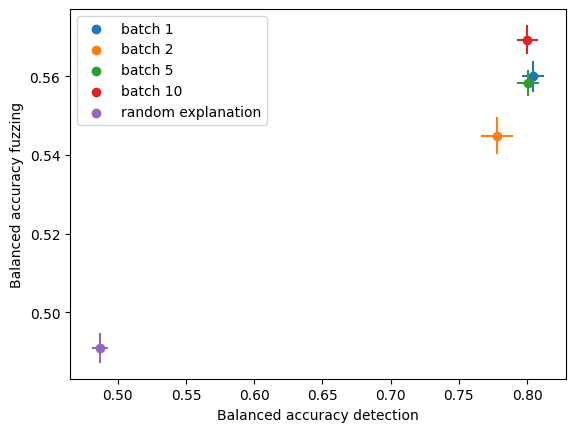

In [18]:
pareto_accuracy(["gpt2_batch","gpt2_batch_2","gpt2_batch_5","gpt2_batch_10","gpt2_random"],["batch 1","batch 2","batch 5","batch 10","random explanation"])

100%|██████████| 354/354 [00:00<00:00, 3035.99it/s]


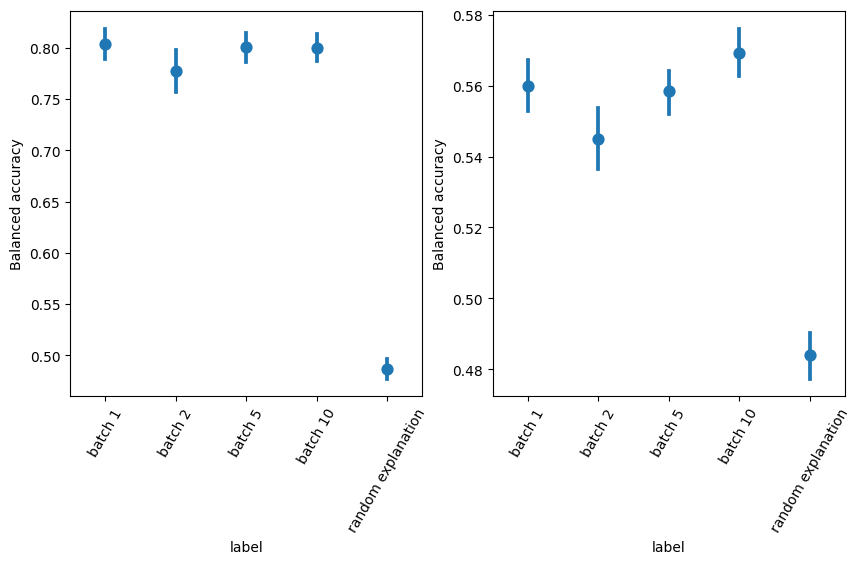

In [156]:
accuracy_lineplot(["gpt2_batch","gpt2_batch_2","gpt2_batch_5","gpt2_batch_10","gpt2_random"],["batch 1","batch 2","batch 5","batch 10","random explanation"],both=True)

100%|██████████| 327/327 [00:00<00:00, 4826.81it/s]


100%|██████████| 354/354 [00:00<00:00, 2384.88it/s]


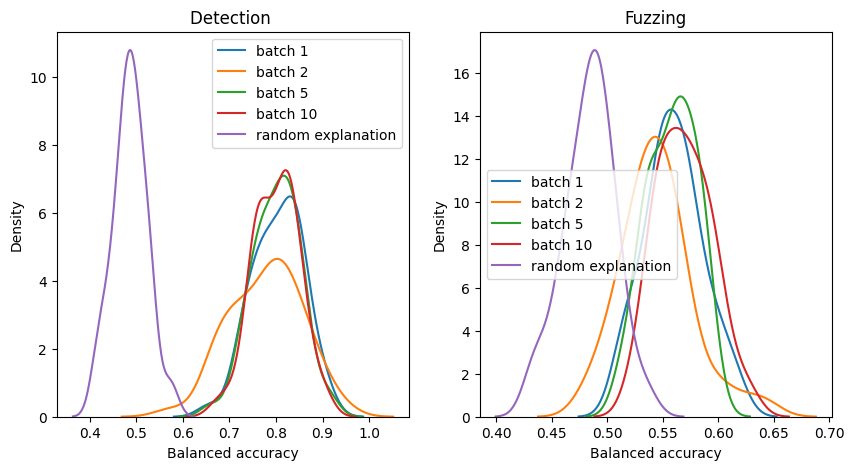

In [157]:
accuracy_distribution(["gpt2_batch","gpt2_batch_2","gpt2_batch_5","gpt2_batch_10","gpt2_random"],["batch 1","batch 2","batch 5","batch 10","random explanation"],both=True,kde=True)

0it [00:00, ?it/s]


ValueError: too many values to unpack (expected 2)

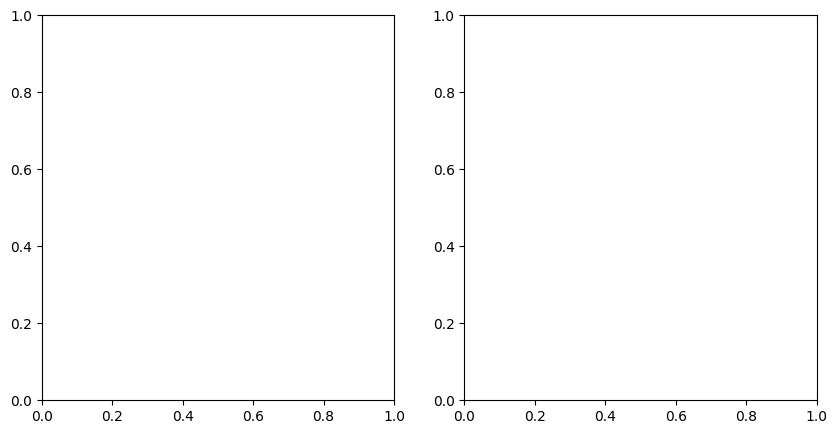

In [234]:
right_per_quantile(["gpt2_batch","gpt2_batch_2","gpt2_batch_5","gpt2_batch_10","gpt2_random"],["batch 1","batch 2","batch 5","batch 10","random explanation"],both=True)

In [32]:
detector_claude, fuzzing_claude = feature_accuracy("scores/gpt2_random_top_200_20")

100%|██████████| 354/354 [00:00<00:00, 517.25it/s]


In [40]:
feature=".transformer.h.11_feature1"
print(detector_claude[feature],fuzzing_claude[feature])

0.44285714285714284 0.5321428571428571


# Evaluator model

100%|██████████| 354/354 [00:00<00:00, 4997.52it/s]


100%|██████████| 354/354 [00:00<00:00, 5112.47it/s]


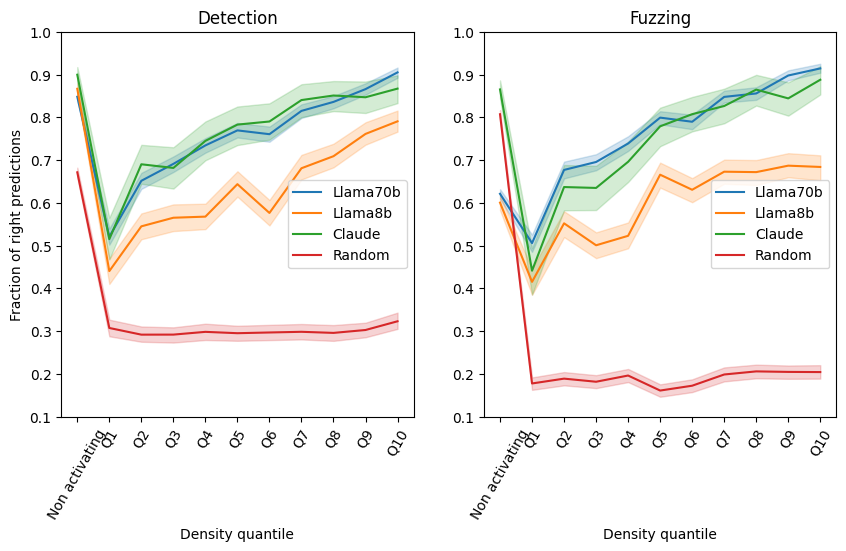

In [41]:
right_per_quantile(["gpt2_simple","gpt2_simple_smaller","gpt2_simple_bigger","gpt2_random"],["Llama70b","Llama8b","Claude","Random"],name="gpt2_model_evaluator",both=True)

100%|██████████| 354/354 [00:00<00:00, 5312.82it/s]


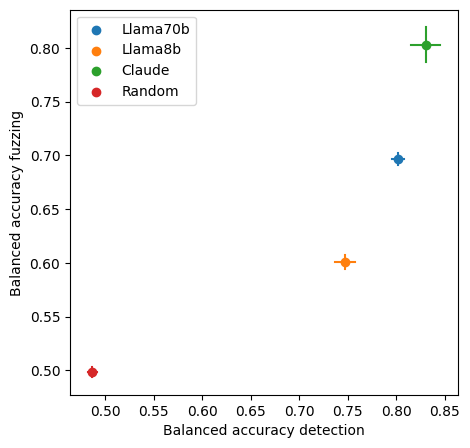

In [47]:
pareto_accuracy(["gpt2_simple","gpt2_simple_smaller","gpt2_simple_bigger","gpt2_random"],["Llama70b","Llama8b","Claude","Random"],name="gpt2_model_evaluator")

In [15]:
detector_70, fuzzing_70 = feature_accuracy("scores/gpt2_simple")
detector_8, fuzzing_8 = feature_accuracy("scores/gpt2_simple_smaller")
detector_claude, fuzzing_claude = feature_accuracy("scores/gpt2_simple_bigger")

100%|██████████| 167/167 [00:00<00:00, 835.88it/s]


In [16]:
detector_70_db = pd.DataFrame(detector_70.items(),columns=["feature","balanced_accuracy"])
fuzzing_70_db = pd.DataFrame(fuzzing_70.items(),columns=["feature","balanced_accuracy"])
detector_8_db = pd.DataFrame(detector_8.items(),columns=["feature","balanced_accuracy"])
fuzzing_8_db = pd.DataFrame(fuzzing_8.items(),columns=["feature","balanced_accuracy"])
detector_claude_db = pd.DataFrame(detector_claude.items(),columns=["feature","balanced_accuracy"])
fuzzing_claude_db = pd.DataFrame(fuzzing_claude.items(),columns=["feature","balanced_accuracy"])
merge_detector_claude_70 = pd.merge(detector_claude_db, detector_70_db, on="feature",suffixes=("_claude","_70"))
merge_fuzz_claude_70 = pd.merge(fuzzing_claude_db, fuzzing_70_db, on="feature",suffixes=("_claude","_70"))
merge_detector_70_8 = pd.merge(detector_70_db, detector_8_db, on="feature",suffixes=("_70","_8"))
merge_fuzz_70_8 = pd.merge(fuzzing_70_db, fuzzing_8_db, on="feature",suffixes=("_70","_8"))

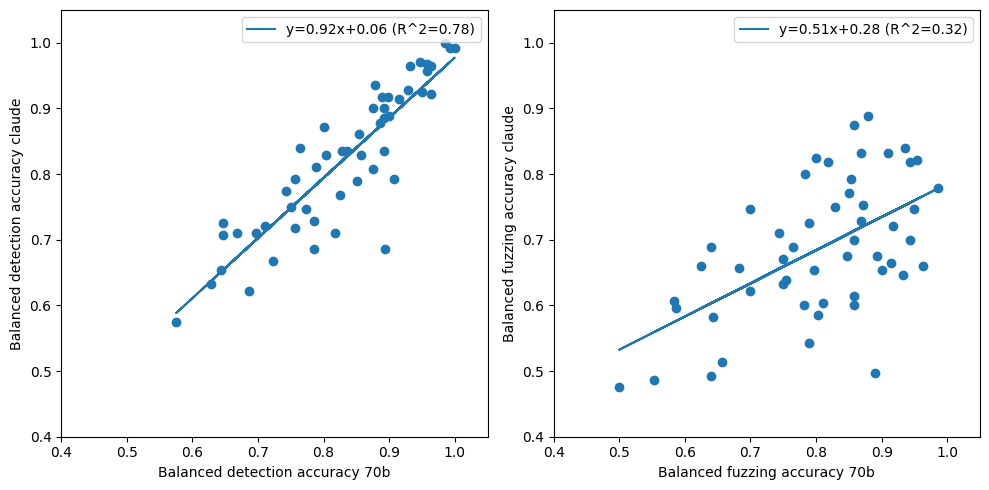

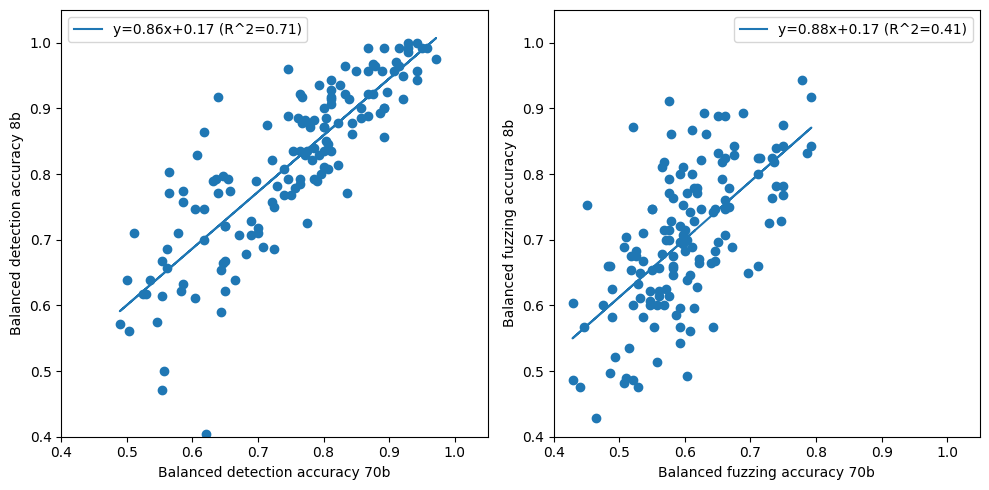

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(merge_detector_claude_70["balanced_accuracy_claude"],merge_detector_claude_70["balanced_accuracy_70"])
#Least squares fit
m, b = np.polyfit(merge_detector_claude_70["balanced_accuracy_claude"],merge_detector_claude_70["balanced_accuracy_70"], 1)
#R^2
r_squared = 1 - (np.sum((merge_detector_claude_70["balanced_accuracy_70"] - m*merge_detector_claude_70["balanced_accuracy_claude"] - b)**2)/np.sum((merge_detector_claude_70["balanced_accuracy_70"] - np.mean(merge_detector_claude_70["balanced_accuracy_70"]))**2))

ax[0].plot(merge_detector_claude_70["balanced_accuracy_claude"], m*merge_detector_claude_70["balanced_accuracy_claude"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")
ax[0].set_ylabel("Balanced detection accuracy claude")
ax[0].set_xlabel("Balanced detection accuracy 70b")
ax[0].legend()
ax[0].set_ylim(0.4,1.05)
ax[0].set_xlim(0.4,1.05)

ax[1].scatter(merge_fuzz_claude_70["balanced_accuracy_claude"],merge_fuzz_claude_70["balanced_accuracy_70"])
m, b = np.polyfit(merge_fuzz_claude_70["balanced_accuracy_claude"],merge_fuzz_claude_70["balanced_accuracy_70"], 1)
r_squared = 1 - (np.sum((merge_fuzz_claude_70["balanced_accuracy_70"] - m*merge_fuzz_claude_70["balanced_accuracy_claude"] - b)**2)/np.sum((merge_fuzz_claude_70["balanced_accuracy_70"] - np.mean(merge_fuzz_claude_70["balanced_accuracy_70"]))**2))

ax[1].plot(merge_fuzz_claude_70["balanced_accuracy_claude"], m*merge_fuzz_claude_70["balanced_accuracy_claude"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")
ax[1].set_ylabel("Balanced fuzzing accuracy claude")
ax[1].set_xlabel("Balanced fuzzing accuracy 70b")
ax[1].legend()
ax[1].set_ylim(0.4,1.05)
ax[1].set_xlim(0.4,1.05)
fig.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(merge_detector_70_8["balanced_accuracy_8"],merge_detector_70_8["balanced_accuracy_70"])
m, b = np.polyfit(merge_detector_70_8["balanced_accuracy_8"],merge_detector_70_8["balanced_accuracy_70"], 1)
r_squared = 1 - (np.sum((merge_detector_70_8["balanced_accuracy_70"] - m*merge_detector_70_8["balanced_accuracy_8"] - b)**2)/np.sum((merge_detector_70_8["balanced_accuracy_70"] - np.mean(merge_detector_70_8["balanced_accuracy_70"]))**2))

ax[0].plot(merge_detector_70_8["balanced_accuracy_8"], m*merge_detector_70_8["balanced_accuracy_8"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")
ax[0].set_ylabel("Balanced detection accuracy 8b")
ax[0].set_xlabel("Balanced detection accuracy 70b")
ax[0].legend()
ax[0].set_ylim(0.4,1.05)
ax[0].set_xlim(0.4,1.05)


ax[1].scatter(merge_fuzz_70_8["balanced_accuracy_8"],merge_fuzz_70_8["balanced_accuracy_70"])
m, b = np.polyfit(merge_fuzz_70_8["balanced_accuracy_8"],merge_fuzz_70_8["balanced_accuracy_70"], 1)
r_squared = 1 - (np.sum((merge_fuzz_70_8["balanced_accuracy_70"] - m*merge_fuzz_70_8["balanced_accuracy_8"] - b)**2)/np.sum((merge_fuzz_70_8["balanced_accuracy_70"] - np.mean(merge_fuzz_70_8["balanced_accuracy_70"]))**2))

ax[1].plot(merge_fuzz_70_8["balanced_accuracy_8"], m*merge_fuzz_70_8["balanced_accuracy_8"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")
ax[1].set_ylabel("Balanced fuzzing accuracy 8b")
ax[1].set_xlabel("Balanced fuzzing accuracy 70b")
ax[1].legend()
ax[1].set_ylim(0.4,1.05)
ax[1].set_xlim(0.4,1.05)
fig.tight_layout()


# Fixing fuzz

100%|██████████| 205/205 [00:00<00:00, 4999.58it/s]


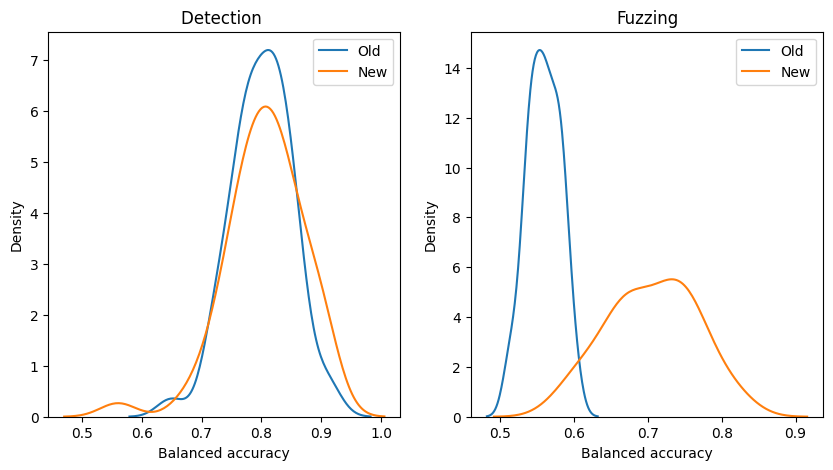

In [105]:
accuracy_distribution(["gpt2_split_top_200_20_all_20","gpt2_new_fuzz"],["Old","New"],both=True,kde=True)

100%|██████████| 354/354 [00:00<00:00, 5274.13it/s]


100%|██████████| 243/243 [00:00<00:00, 4759.42it/s]


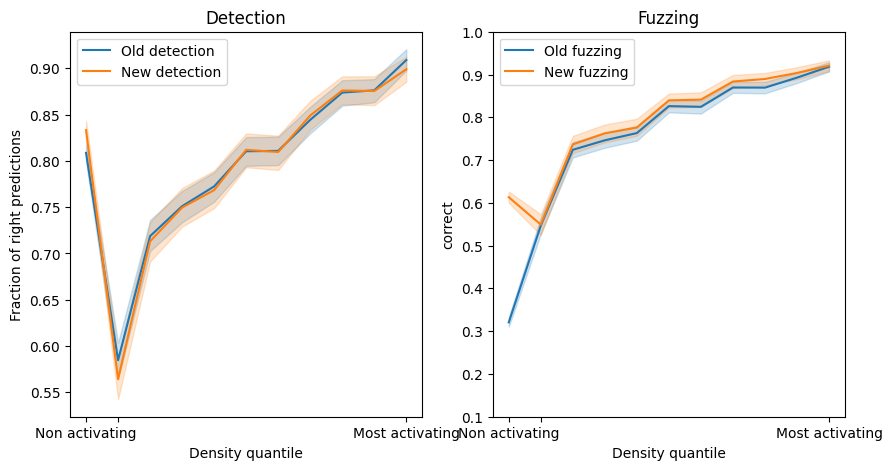

In [106]:
right_per_quantile(["gpt2_split_top_200_20_all_20","gpt2_new_fuzz"],["Old","New"],both=True)

100%|██████████| 205/205 [00:00<00:00, 4900.14it/s]


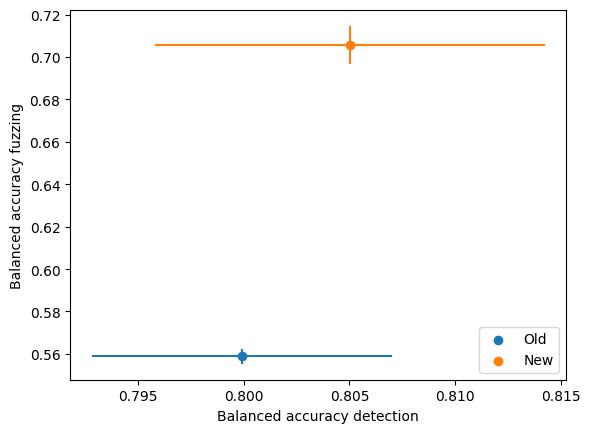

In [103]:
pareto_accuracy(["gpt2_split_top_200_20_all_20","gpt2_new_fuzz"],["Old","New"])

# COT vs Simple

100%|██████████| 354/354 [00:00<00:00, 5467.61it/s]


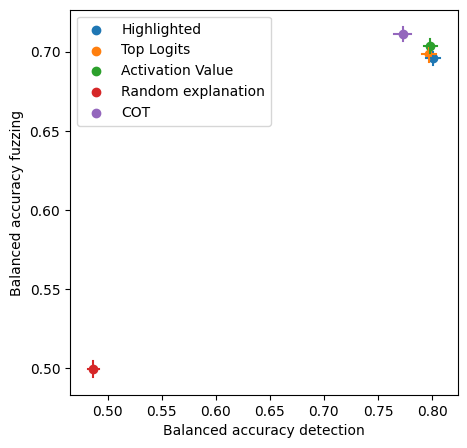

In [18]:
pareto_accuracy(["gpt2_simple","gpt2_logit","gpt2_activation","gpt2_random","gpt2_cot"],["Highlighted","Top Logits","Activation Value","Random explanation","COT"],name="gpt2_cot")

100%|██████████| 354/354 [00:00<00:00, 5179.40it/s]


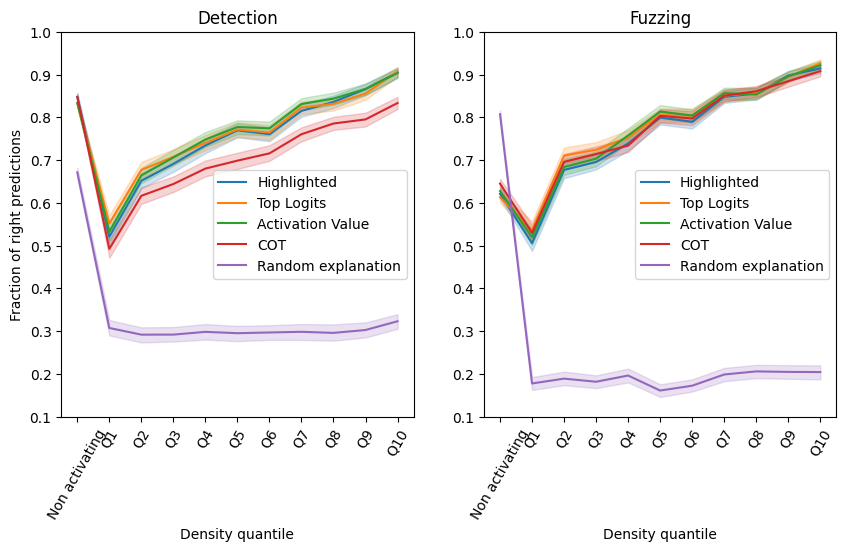

In [33]:
right_per_quantile(["gpt2_simple","gpt2_logit","gpt2_activation","gpt2_cot","gpt2_random"],["Highlighted","Top Logits","Activation Value","COT","Random explanation"],name="gpt2_cot",both=True)

  6%|▌         | 25/419 [00:00<00:02, 196.81it/s]

100%|██████████| 419/419 [00:00<00:00, 716.00it/s]


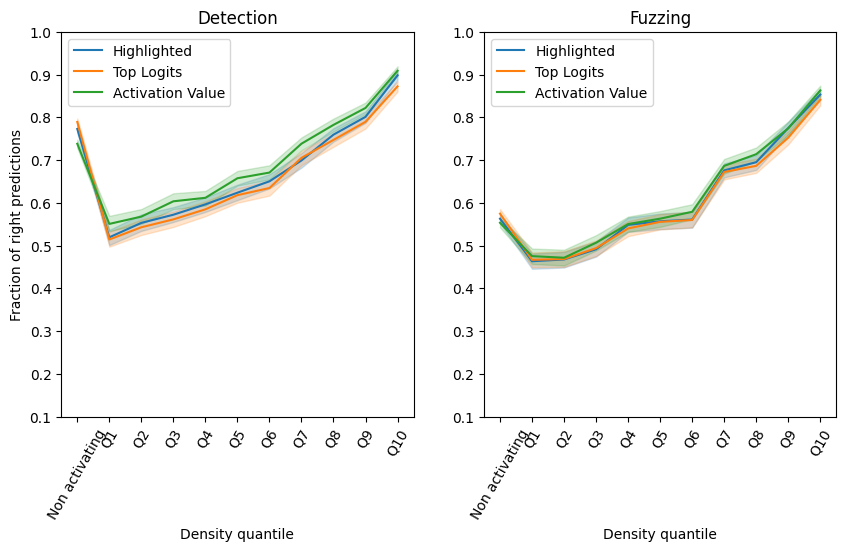

In [14]:
right_per_quantile(["llamav2_simple","llamav2_logit","llamav2_activation"],["Highlighted","Top Logits","Activation Value"],both=True)

100%|██████████| 419/419 [00:00<00:00, 5398.39it/s]


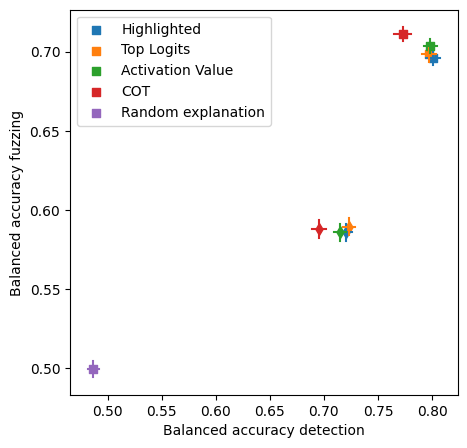

In [27]:
pareto_accuracy(["gpt2_simple","gpt2_logit","gpt2_activation","gpt2_cot","gpt2_random","llamav2_simple","llamav2_logit","llamav2_activation","llamav2_cot"],["Highlighted","Top Logits","Activation Value","COT","Random explanation"],name="cot")

 12%|█▏        | 50/419 [00:00<00:00, 488.17it/s]

100%|██████████| 419/419 [00:00<00:00, 632.74it/s]


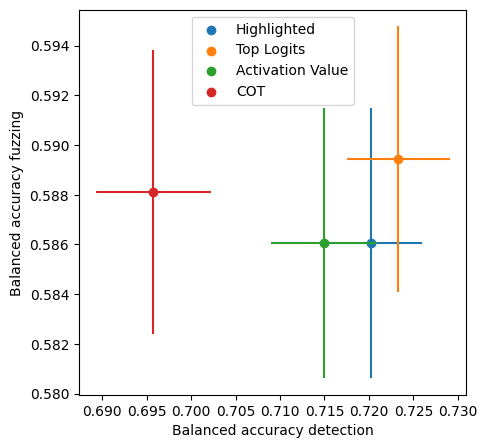

In [16]:
pareto_accuracy(["llamav2_simple","llamav2_logit","llamav2_activation","llamav2_cot"],["Highlighted","Top Logits","Activation Value","COT"])

100%|██████████| 200/200 [00:00<00:00, 5210.87it/s]


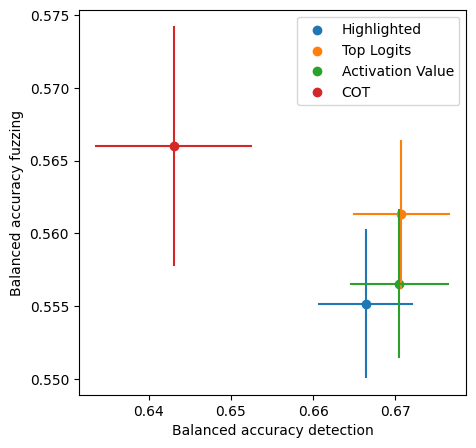

In [16]:
pareto_accuracy(["llamav1_simple","llamav1_logit","llamav1_activation","llamav1_cot"],["Highlighted","Top Logits","Activation Value","COT"])

 14%|█▍        | 63/451 [00:00<00:00, 624.96it/s]

100%|██████████| 200/200 [00:00<00:00, 968.15it/s]


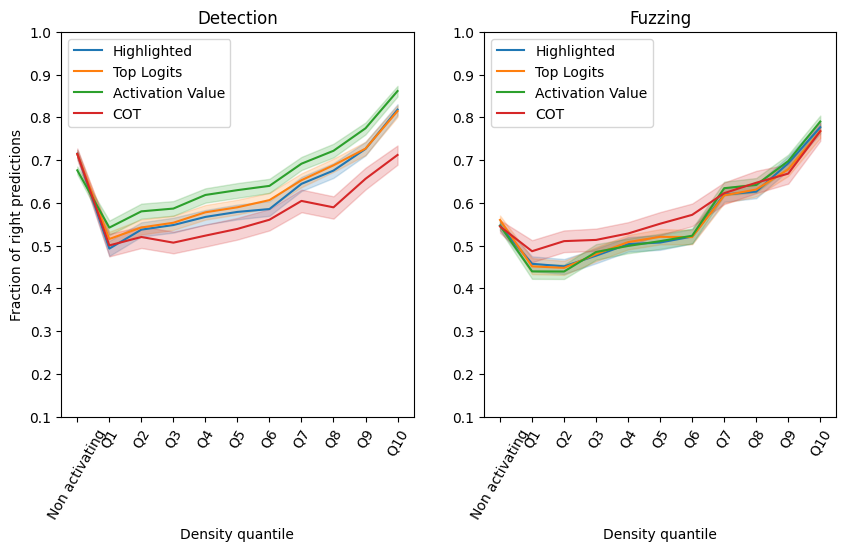

In [15]:
right_per_quantile(["llamav1_simple","llamav1_logit","llamav1_activation","llamav1_cot"],["Highlighted","Top Logits","Activation Value","COT"],both=True)

100%|██████████| 354/354 [00:00<00:00, 4604.97it/s]


100%|██████████| 354/354 [00:00<00:00, 5287.18it/s]


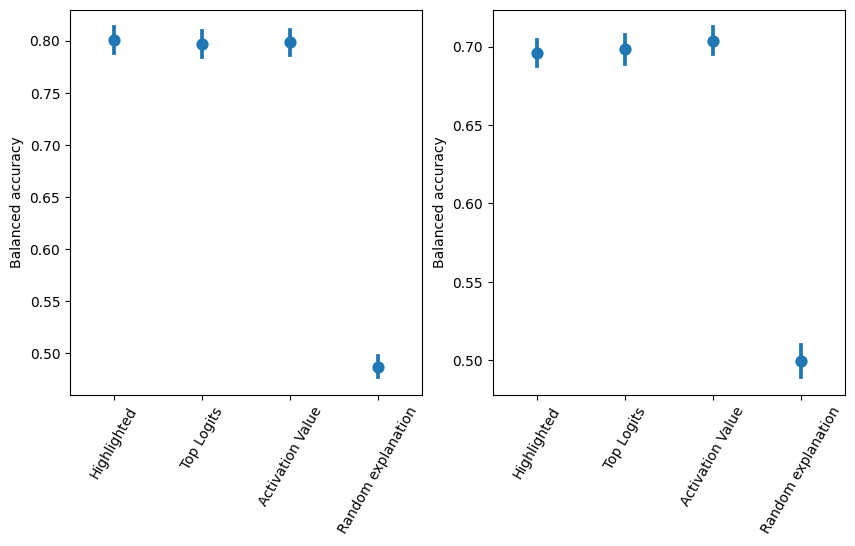

In [50]:
accuracy_lineplot(["gpt2_simple","gpt2_logit","gpt2_activation","gpt2_random"],["Highlighted","Top Logits","Activation Value","Random explanation"],both=True)

100%|██████████| 354/354 [00:00<00:00, 3617.37it/s]


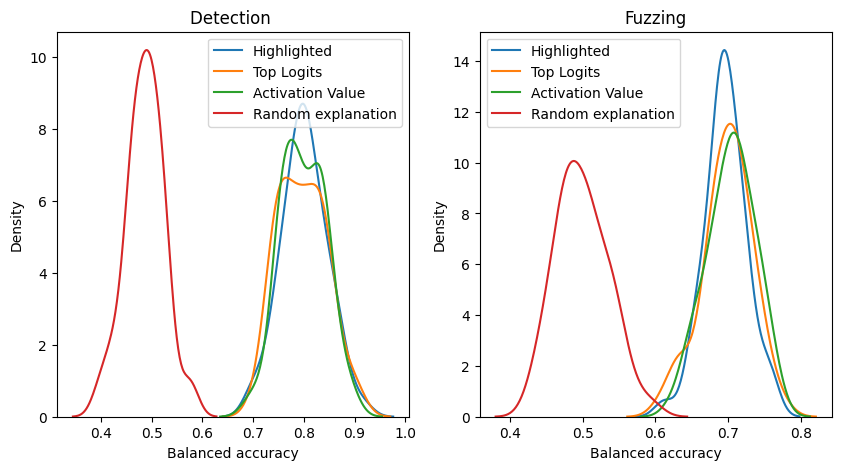

In [51]:
accuracy_distribution(["gpt2_simple","gpt2_logit","gpt2_activation","gpt2_random"],["Highlighted","Top Logits","Activation Value","Random explanation"],both=True,kde=True)

# Models

100%|██████████| 419/419 [00:00<00:00, 5236.32it/s]


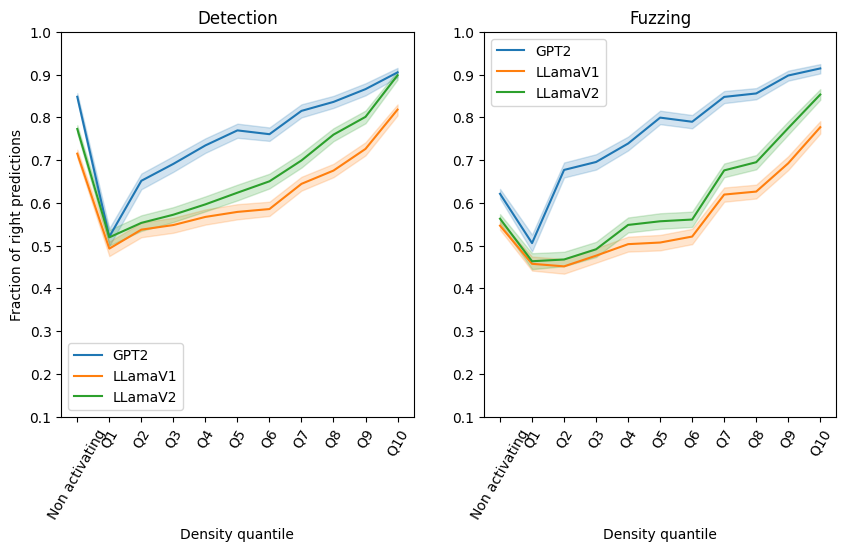

In [19]:
right_per_quantile(["gpt2_simple","llamav1_simple","llamav2_simple"],["GPT2","LLamaV1","LLamaV2"],both=True)

100%|██████████| 354/354 [00:00<00:00, 422.98it/s]


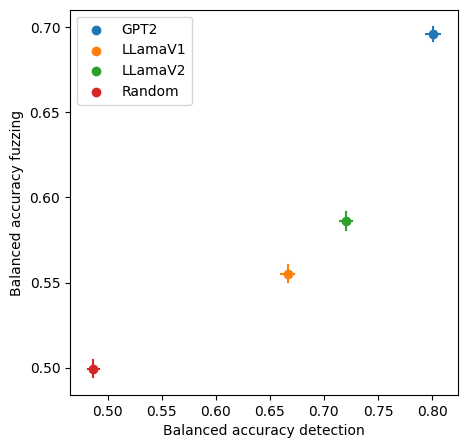

In [17]:
pareto_accuracy(["gpt2_simple","llamav1_simple","llamav2_simple","gpt2_random"],["GPT2","LLamaV1","LLamaV2","Random"])

100%|██████████| 33/33 [00:00<00:00, 1125.68it/s]


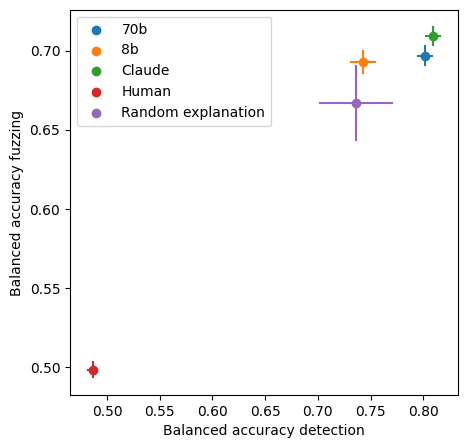

In [23]:
pareto_accuracy(["gpt2_simple","gpt2_llama8b","gpt2_claude","gpt2_random","gpt2_human"],["70b","8b","Claude","Human","Random explanation"],name="gpt2_model_evaluator")

100%|██████████| 354/354 [00:00<00:00, 5036.32it/s]


100%|██████████| 33/33 [00:00<00:00, 4719.61it/s]


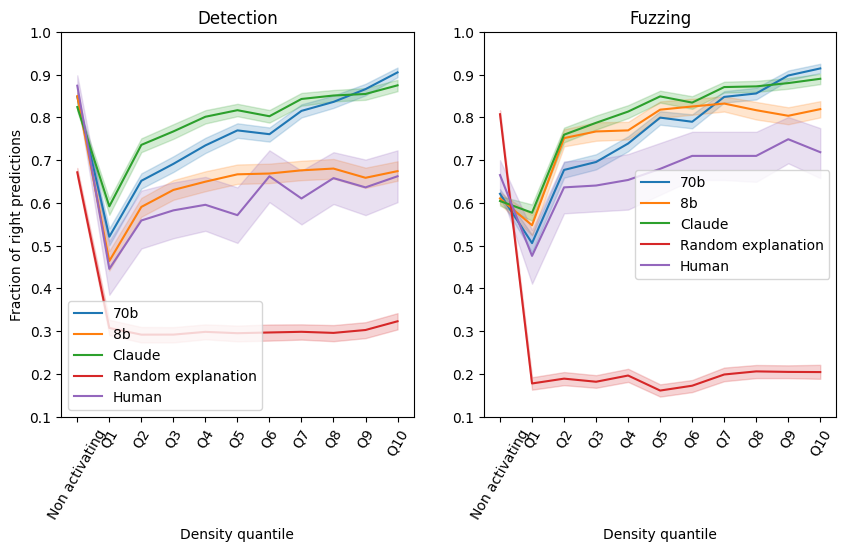

In [24]:
right_per_quantile(["gpt2_simple","gpt2_llama8b","gpt2_claude","gpt2_random","gpt2_human"],["70b","8b","Claude","Random explanation","Human"],both=True,name="gpt2_model_evaluator")

100%|██████████| 33/33 [00:00<00:00, 5018.02it/s]


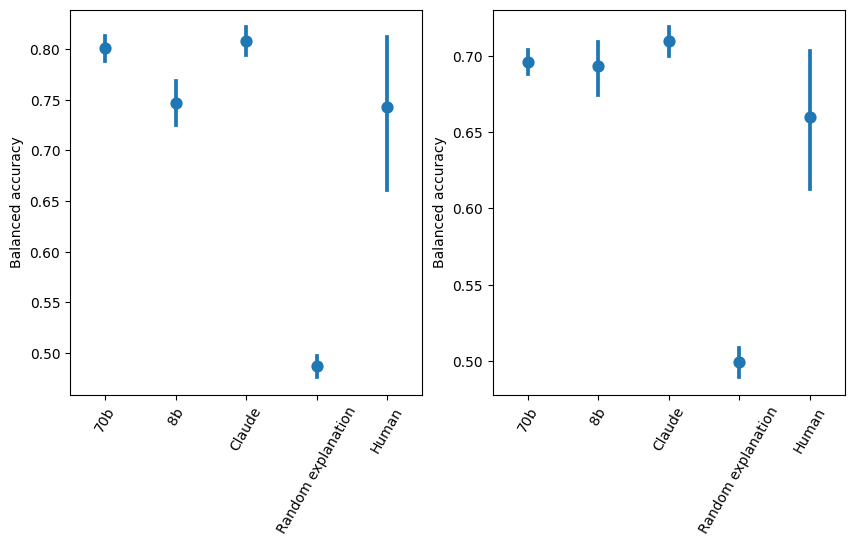

In [54]:
accuracy_lineplot(["gpt2_simple","gpt2_llama8b","gpt2_claude","gpt2_random","gpt2_human"],["70b","8b","Claude","Random explanation","Human"],both=True)

# Nora

100%|██████████| 383/383 [00:00<00:00, 908.21it/s]


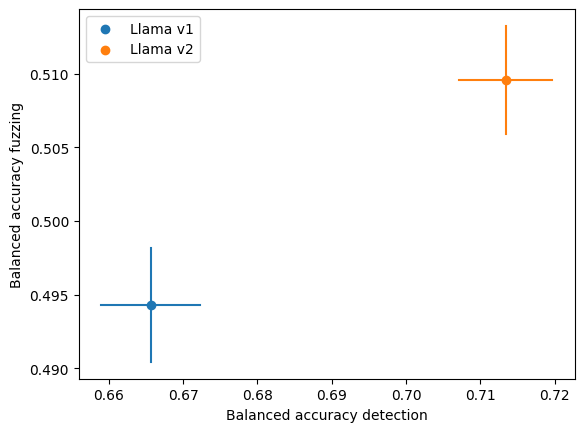

In [186]:
pareto_accuracy(["llama_v1","llama_v2"],["Llama v1","Llama v2"])

100%|██████████| 383/383 [00:00<00:00, 3757.67it/s]


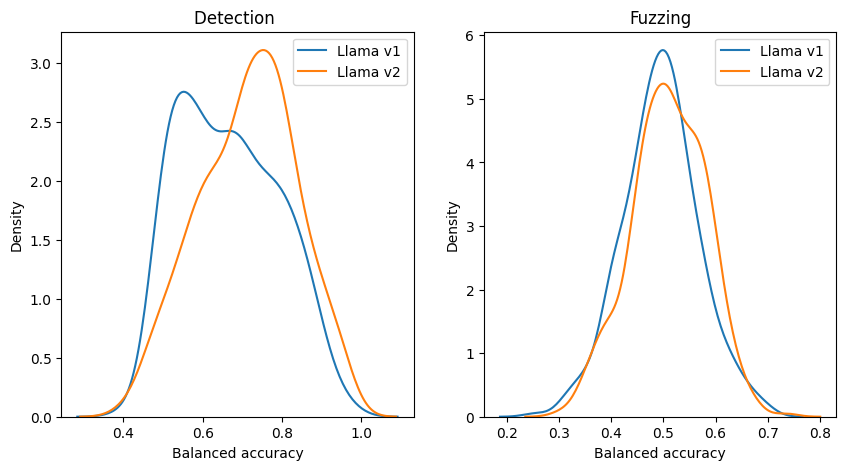

In [187]:
accuracy_distribution(["llama_v1","llama_v2"],["Llama v1","Llama v2"],both=True,kde=True)

100%|██████████| 298/298 [00:00<00:00, 5125.11it/s]


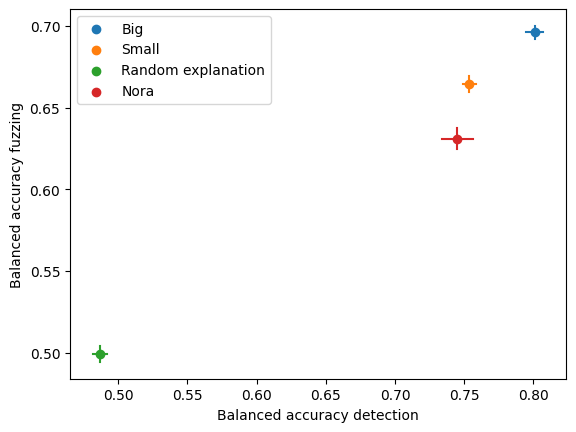

In [228]:
pareto_accuracy(["gpt2_simple","gpt2_small","gpt2_random","gpt2_nora"],["Big","Small","Random explanation","Nora"])

100%|██████████| 354/354 [00:00<00:00, 4444.78it/s]


100%|██████████| 298/298 [00:00<00:00, 3957.97it/s]


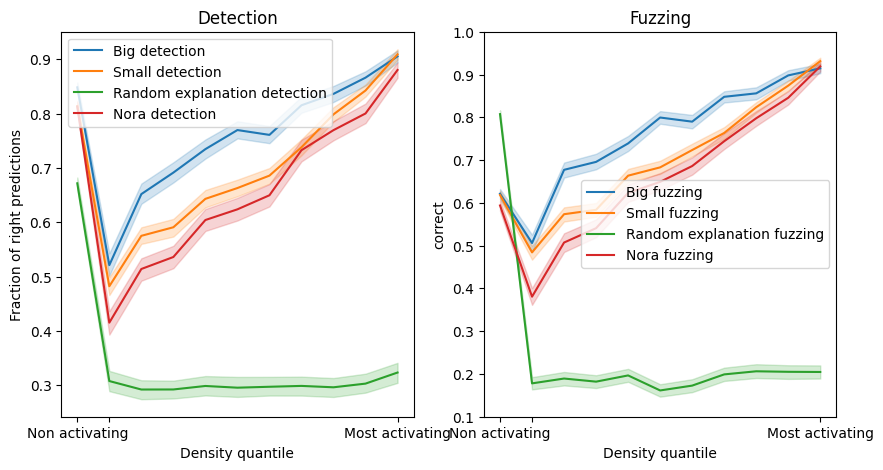

In [229]:
right_per_quantile(["gpt2_simple","gpt2_small","gpt2_random","gpt2_nora"],["Big","Small","Random explanation","Nora"],both=True)

100%|██████████| 354/354 [00:00<00:00, 3484.14it/s]


100%|██████████| 356/356 [00:00<00:00, 3610.08it/s]


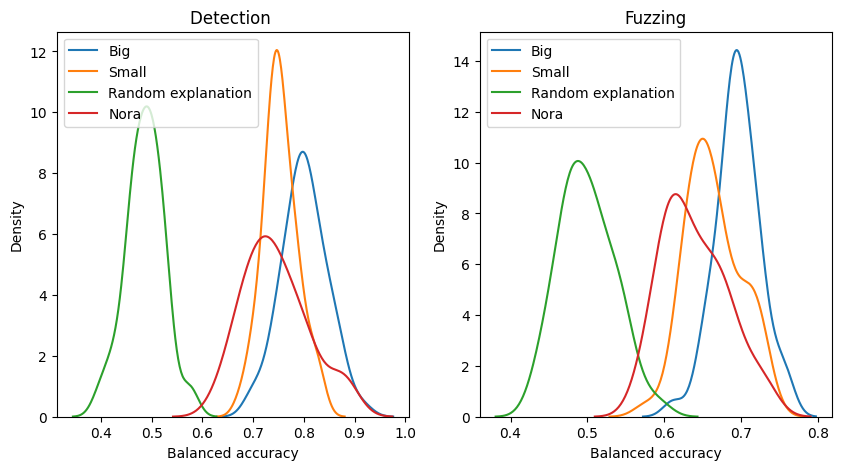

In [230]:
accuracy_distribution(["gpt2_simple","gpt2_small","gpt2_random","gpt2_nora"],["Big","Small","Random explanation","Nora"],both=True,kde=True)

# Sampling techniques

100%|██████████| 354/354 [00:00<00:00, 3886.76it/s]


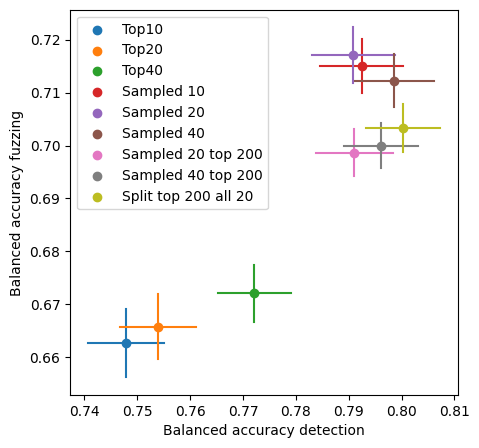

In [256]:
pareto_accuracy(["gpt2_top_10","gpt2_top_20","gpt2_top_40","gpt2_random_10","gpt2_random_20","gpt2_random_40","gpt2_random_top_200_20","gpt2_random_top_200_40","gpt2_split_top_200_20_all_20"],["Top10","Top20","Top40","Sampled 10","Sampled 20","Sampled 40","Sampled 20 top 200","Sampled 40 top 200","Split top 200 all 20"])

  0%|          | 0/354 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 672.32it/s]


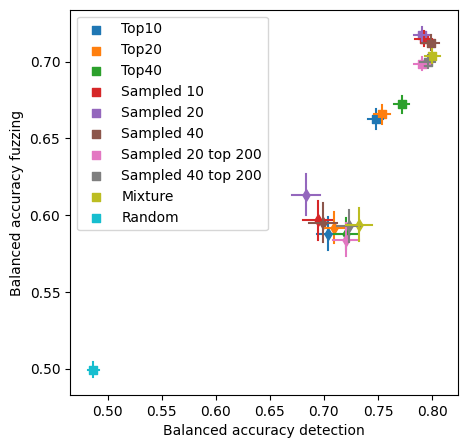

In [15]:
pareto_accuracy(["gpt2_top_10","gpt2_top_20","gpt2_top_40","gpt2_random_10","gpt2_random_20","gpt2_random_40","gpt2_random_top_200_20","gpt2_random_top_200_40","gpt2_split_top_200_20_all_20","gpt2_random","llamav2_top_10","llamav2_top_20","llamav2_top_40","llamav2_random_10","llamav2_random_20","llamav2_random_40","llamav2_random_top_200_20","llamav2_random_top_200_40","llamav2_split_top_200_20_all_20"],["Top10","Top20","Top40","Sampled 10","Sampled 20","Sampled 40","Sampled 20 top 200","Sampled 40 top 200","Mixture","Random"],name="Sampling")

 56%|█████▌    | 56/100 [00:00<00:00, 558.54it/s]

100%|██████████| 100/100 [00:00<00:00, 734.57it/s]


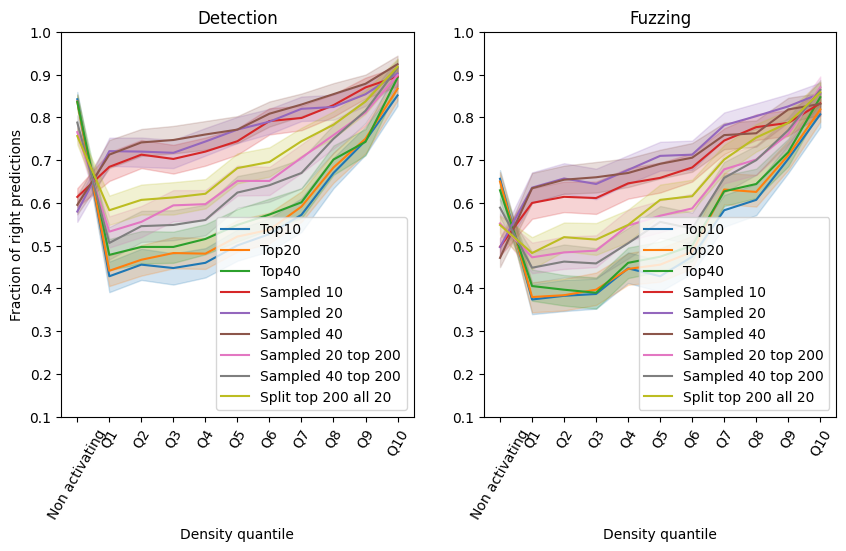

In [18]:
right_per_quantile(["llamav2_top_10","llamav2_top_20","llamav2_top_40","llamav2_random_10","llamav2_random_20","llamav2_random_40","llamav2_random_top_200_20","llamav2_random_top_200_40","llamav2_split_top_200_20_all_20"],["Top10","Top20","Top40","Sampled 10","Sampled 20","Sampled 40","Sampled 20 top 200","Sampled 40 top 200","Split top 200 all 20"],both=True)

100%|██████████| 354/354 [00:00<00:00, 4907.92it/s]


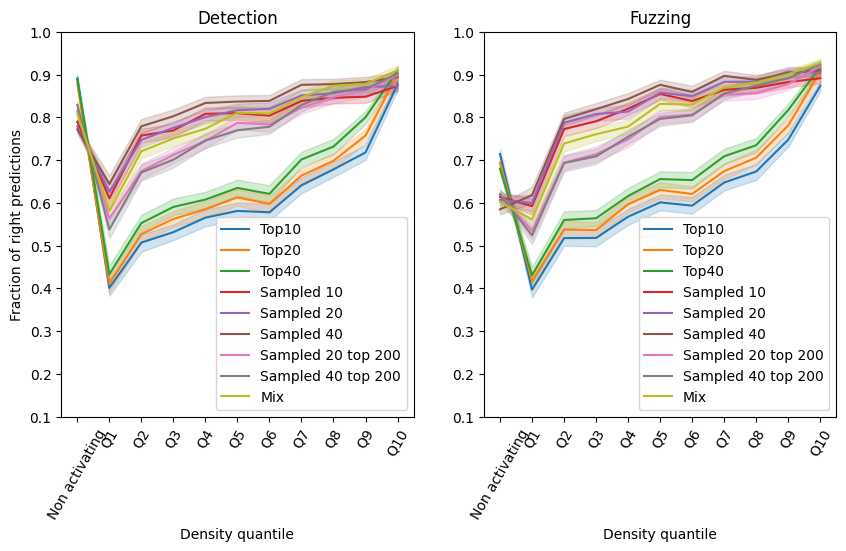

In [38]:
right_per_quantile(["gpt2_top_10","gpt2_top_20","gpt2_top_40","gpt2_random_10","gpt2_random_20","gpt2_random_40","gpt2_random_top_200_20","gpt2_random_top_200_40","gpt2_split_top_200_20_all_20"],["Top10","Top20","Top40","Sampled 10","Sampled 20","Sampled 40","Sampled 20 top 200","Sampled 40 top 200","Mix"],"sampling",both=True)

100%|██████████| 354/354 [00:00<00:00, 3582.66it/s]


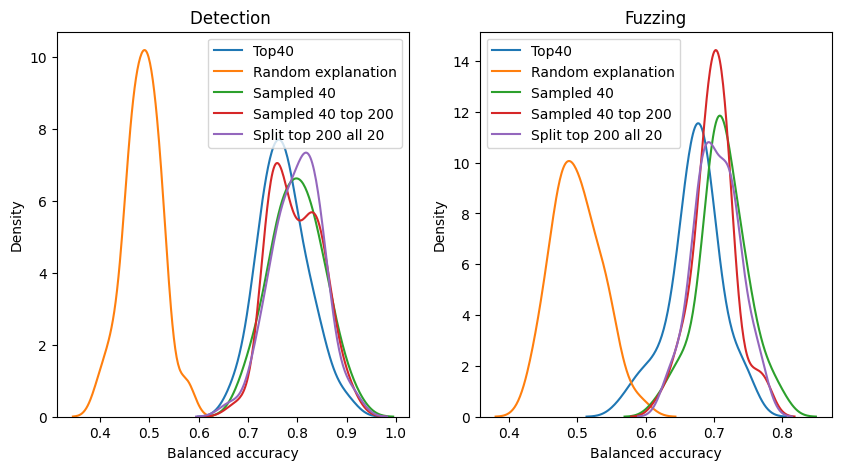

In [249]:
accuracy_distribution(["gpt2_top_40","gpt2_random","gpt2_random_40","gpt2_random_top_200_40","gpt2_split_top_200_20_all_20"],["Top40","Random explanation","Sampled 40","Sampled 40 top 200","Split top 200 all 20"],both=True,kde=True)

# Simulation score

In [18]:
directory = "scores/gpt2_sim"
all_data={}
for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            ev_correlation_score = data["result"]["ev_correlation_score"]
            feature = filename.split(".txt")[0]
            if ev_correlation_score != "nan": 
                all_data[feature]=float(ev_correlation_score)
            else:
                all_data[feature]=0
dataframe = pd.DataFrame(all_data.items(),columns=["feature","ev_correlation_score"])
                

100%|██████████| 352/352 [00:00<00:00, 1065.28it/s]


Text(0.5, 0, 'Ev correlation score')

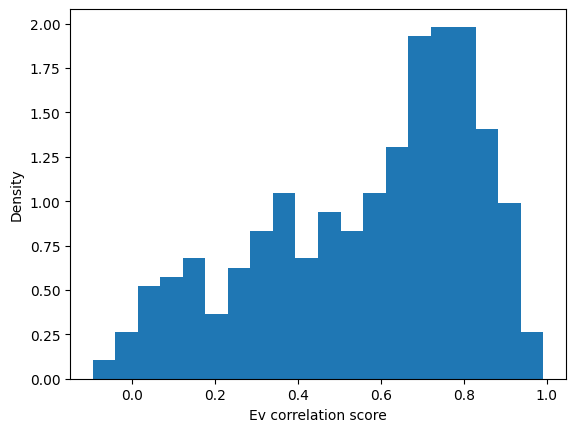

In [26]:
plt.hist(dataframe["ev_correlation_score"],bins=20,density=True)
plt.ylabel("Density")
plt.xlabel("Ev correlation score")

In [46]:
detector_scores, fuzzing_scores = balanced_accuracy_vs_sim("scores/gpt2_top_10")
dataframe_detector = pd.DataFrame(detector_scores.items(),columns=["feature","detector_score"])
dataframe_fuzzing = pd.DataFrame(fuzzing_scores.items(),columns=["feature","fuzzing_score"])

100%|██████████| 354/354 [00:00<00:00, 4374.58it/s]


In [47]:
import plotly.express as px
merged = pd.merge(dataframe_detector,dataframe_fuzzing,on="feature")

#Make it a square scatter plot

m, b = np.polyfit(merged["fuzzing_score"],merged["detector_score"], 1)
r_squared = 1 - (np.sum((merged["detector_score"] - m*merged["fuzzing_score"] - b)**2)/np.sum((merged["detector_score"] - np.mean(merged["detector_score"]))**2))

# R^2

print(r_squared)
px.scatter(merged,x="detector_score",y="fuzzing_score",hover_name="feature",width=800,height=800,marginal_x="histogram",marginal_y="histogram",trendline="ols")


0.186280188443541


In [15]:
detector_scores, fuzzing_scores = balanced_accuracy_vs_sim("scores/gpt2_split_top_200_20_all_20")
dataframe_detector = pd.DataFrame(detector_scores.items(),columns=["feature","detector_score"])
dataframe_fuzzing = pd.DataFrame(fuzzing_scores.items(),columns=["feature","fuzzing_score"])

100%|██████████| 354/354 [00:00<00:00, 4142.11it/s]


In [31]:
import plotly.express as px
merged = pd.merge(dataframe_detector,dataframe_fuzzing,on="feature")

#Make it a square scatter plot

r_squared = 1 - (np.sum((merged["detector_score"] - m*merged["fuzzing_score"] - b)**2)/np.sum((merged["detector_score"] - np.mean(merged["detector_score"]))**2))
m, b = np.polyfit(merged["fuzzing_score"],merged["detector_score"], 1)
# R^2

px.scatter(merged,x="detector_score",y="fuzzing_score",hover_name="feature",width=800,height=800,marginal_x="histogram",marginal_y="histogram",trendline="ols")




(0.4, 1.05)

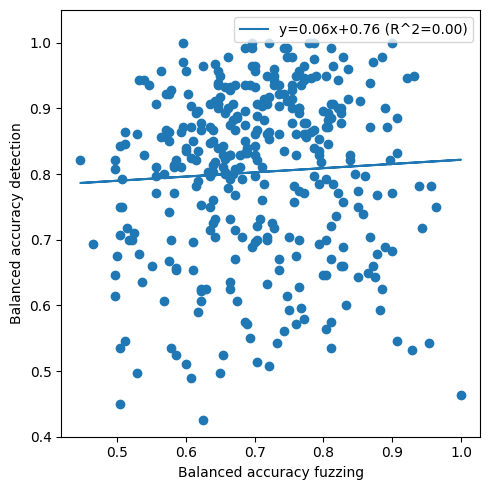

In [22]:
# Merge the two dataframes, keeping only the same features
merged = pd.merge(dataframe_detector, dataframe, on="feature")
merged = pd.merge(merged, dataframe_fuzzing, on="feature")
# Calculate the correlation between the ev correlation score and the balanced accuracy
plt.figure(figsize=(5,5))
plt.scatter(merged["fuzzing_score"],merged["detector_score"])
# Least squares fit
m, b = np.polyfit(merged["fuzzing_score"],merged["detector_score"], 1)
# R^2
r_squared = 1 - (np.sum((merged["detector_score"] - m*merged["fuzzing_score"] - b)**2)/np.sum((merged["detector_score"] - np.mean(merged["detector_score"]))**2))
plt.plot(merged["fuzzing_score"], m*merged["fuzzing_score"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")

plt.legend()
plt.ylabel("Balanced accuracy detection")
plt.xlabel("Balanced accuracy fuzzing")
plt.tight_layout()
plt.ylim(0.4,1.05)

(0.4, 1.05)

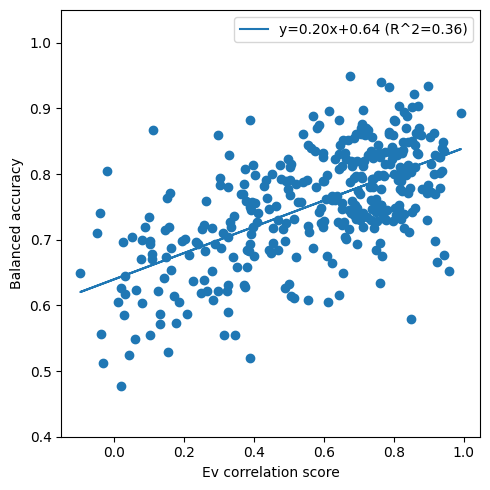

In [29]:
# Merge the two dataframes, keeping only the same features
merged = pd.merge(dataframe_detector, dataframe, on="feature")
merged = pd.merge(merged, dataframe_fuzzing, on="feature")
#plt.scatter(merged["ev_correlation_score"],merged["detector_score"])
#plt.scatter(merged["ev_correlation_score"],merged["fuzzing_score"])
#plt.scatter(merged["ev_correlation_score"],np.sqrt(merged["fuzzing_score"]**2+merged["detector_score"]**2))
#plt.scatter(merged["fuzzing_score"],merged["detector_score"])
# Calculate the correlation between the ev correlation score and the balanced accuracy
#merged["new_score"]= np.sqrt(merged["fuzzing_score"]**2+merged["detector_score"]**2)
merged["newer_score"]= (merged["fuzzing_score"]+merged["detector_score"])/2
plt.figure(figsize=(5,5))
plt.scatter(merged["ev_correlation_score"],merged["newer_score"])
# Least squares fit
m, b = np.polyfit(merged["ev_correlation_score"],merged["newer_score"], 1)
# R^2
r_squared = 1 - (np.sum((merged["newer_score"] - m*merged["ev_correlation_score"] - b)**2)/np.sum((merged["newer_score"] - np.mean(merged["newer_score"]))**2))
plt.plot(merged["ev_correlation_score"], m*merged["ev_correlation_score"] + b,label=f"y={m:.2f}x+{b:.2f} (R^2={r_squared:.2f})")
plt.legend()
plt.ylabel("Balanced accuracy")
plt.xlabel("Ev correlation score")
plt.tight_layout()
plt.ylim(0.4,1.05)

In [40]:
import scipy.stats
print(scipy.stats.pearsonr(merged["ev_correlation_score"],merged["new_score"]))
print(scipy.stats.pearsonr(merged["ev_correlation_score"],merged["newer_score"]))

print(scipy.stats.pearsonr(merged["ev_correlation_score"],merged["detector_score"]))
print(scipy.stats.pearsonr(merged["ev_correlation_score"],merged["fuzzing_score"]))
print(scipy.stats.pearsonr(merged["detector_score"],merged["fuzzing_score"]))

#compute R^2
print(np.corrcoef(merged["ev_correlation_score"],merged["new_score"])[0, 1]**2)

PearsonRResult(statistic=0.6126261776724438, pvalue=1.206606796315059e-37)
PearsonRResult(statistic=0.6014937543411258, pvalue=5.203331941925993e-36)
PearsonRResult(statistic=0.5225416171420438, pvalue=4.6943057447519856e-26)
PearsonRResult(statistic=0.3383085269491168, pvalue=7.132984146740213e-11)
PearsonRResult(statistic=0.05424815489025273, pvalue=0.31014735175799757)
0.37531083356954864


# New llama

In [559]:
human_results = analyse("scores/llama_human")
llama_1 = analyse("scores/llama_1")
llama_random = analyse("scores/llama_random")
llama_small = analyse("scores/llama_small")

100%|██████████| 63/63 [00:00<00:00, 445.30it/s]


([<matplotlib.axis.XTick at 0x7fcbcadd3b50>,
 [Text(0, 0, 'Overall'),
  Text(1, 0, 'Non activating'),
  Text(2, 0, 'Q1'),
  Text(3, 0, 'Q2'),
  Text(4, 0, 'Q3'),
  Text(5, 0, 'Q4')])

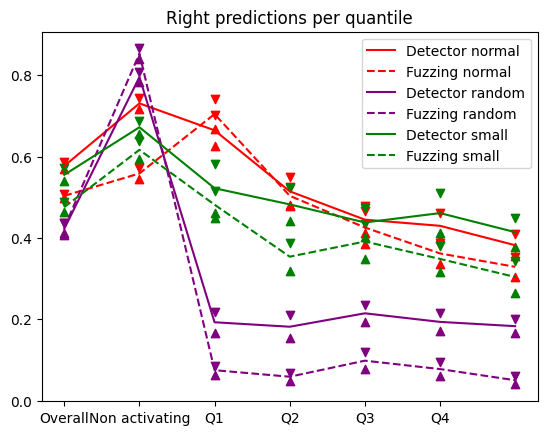

In [560]:
pqad, pqaf, id, ifu,cot_data = llama_1
pqad_s, pqaf_s, id_s, ifu_s,simple_data = human_results
pqad_r, pqaf_r, id_r, ifu_r,random_data = llama_random
pqad_sb, pqaf_sb, id_sb, ifu_sb,simple_data_b = llama_small

# plt.figure()
x = np.arange(len(pqad))
plt.plot(pqad[:,0], label="Detector normal",color="red")
plt.scatter(x,pqad[:,0]+pqad[:,1],color="red",marker="v")
plt.scatter(x,pqad[:,0]-pqad[:,1],color="red",marker="^")
plt.plot(pqaf[:,0], label="Fuzzing normal",color="red",linestyle="--")
plt.scatter(x,pqaf[:,0]+pqaf[:,1],color="red",marker="v")
plt.scatter(x,pqaf[:,0]-pqaf[:,1],color="red",marker="^")


# plt.plot(pqad_s[:,0], label="Detector human",color="blue")
# plt.scatter(x,pqad_s[:,0]+pqad_s[:,1],color="blue",marker="v")
# plt.scatter(x,pqad_s[:,0]-pqad_s[:,1],color="blue",marker="^")
# plt.plot(pqaf_s[:,0], label="Fuzzing human",color="blue",linestyle="--")
# plt.scatter(x,pqaf_s[:,0]+pqaf_s[:,1],color="blue",marker="v")
# plt.scatter(x,pqaf_s[:,0]-pqaf_s[:,1],color="blue",marker="^")

plt.plot(pqad_r[:,0], label="Detector random",color="purple")
plt.scatter(x,pqad_r[:,0]+pqad_r[:,1],color="purple",marker="v")
plt.scatter(x,pqad_r[:,0]-pqad_r[:,1],color="purple",marker="^")
plt.plot(pqaf_r[:,0], label="Fuzzing random",color="purple",linestyle="--")
plt.scatter(x,pqaf_r[:,0]+pqaf_r[:,1],color="purple",marker="v")
plt.scatter(x,pqaf_r[:,0]-pqaf_r[:,1],color="purple",marker="^")

plt.plot(pqad_sb[:,0], label="Detector small",color="green")
plt.scatter(x,pqad_sb[:,0]+pqad_sb[:,1],color="green",marker="v")
plt.scatter(x,pqad_sb[:,0]-pqad_sb[:,1],color="green",marker="^")
plt.plot(pqaf_sb[:,0], label="Fuzzing small",color="green",linestyle="--")
plt.scatter(x,pqaf_sb[:,0]+pqaf_sb[:,1],color="green",marker="v")
plt.scatter(x,pqaf_sb[:,0]-pqaf_sb[:,1],color="green",marker="^")



#plt.plot([0,1,2,3,4,5],[0.1]*6, label="Random",color="green")
plt.legend()
plt.title("Right predictions per quantile")
plt.xticks([0,1,2,3,4,5],["Overall","Non activating","Q1","Q2","Q3","Q4"])


# Anthropic plot

In [41]:
from sae_auto_interp.utils import load_tokenized_data
from nnsight import LanguageModel
from sae_auto_interp.features import  FeatureRecord
import random
from sae_auto_interp.clients import get_client
from sae_auto_interp.scorers import ScorerInput, FuzzingScorer
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

/home/gpaulo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
cd /mnt/ssd-1/gpaulo/SAE-Zoology

/mnt/ssd-1/gpaulo/SAE-Zoology


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [43]:
model = LanguageModel("openai-community/gpt2", device_map="cpu", dispatch=True)

In [44]:
tokens = load_tokenized_data(model.tokenizer,dataset_split="train")

In [45]:

def load_explanation(explanations_dir,feature):
    explanations_path = f"{explanations_dir}/layer{feature}.txt"

    with open(explanations_path, "r") as f:
        explanation = f.read()

    return json.loads(explanation)

In [105]:
def anthropic_plot(idx,folder):
    directory = f"scores/{folder}_all"
    all_data = []
    for filename in tqdm(os.listdir(directory)):
            if filename.endswith('.txt'):
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    data = json.load(file)
                data = data["result"]
                for d in data:
                    #d.pop('text')
                    d["text"] = d["text"].replace("<","")
                    d["text"] = d["text"].replace(">","")
                    feature = filename.split(".txt")[0]
                    d["feature"]=feature
                all_data.extend(data)
    data_df = pd.DataFrame(all_data)
    data_df["correct"] = data_df["ground_truth"] == data_df["predicted"]
    uniques = data_df["feature"].unique()
    choosen = uniques[idx]
    module_name = choosen.split("feature")[0][:-1]
    feature = choosen.split("feature")[-1]
    print(f"Doing: {module_name} {feature}")
    records = FeatureRecord.from_tensor(
        tokens,
        module_name,
        selected_features=[int(feature)],
        raw_dir = "raw_features",
        processed_dir = "processed_features",
        min_examples=2000,
        max_examples=100000
    )
    wanted_data = data_df[data_df["feature"]==choosen]
    explanation = load_explanation(f"saved_explanations/{folder}",choosen)["result"]

    histogram = []
    #print(len(explainer_inputs_20_all_10[i].record.examples))
    nbins=25
    max_activation= records[0].max_activation.item()
    all_correct = [0]*nbins
    all_wrong = [0]*nbins
    detection_correct = [0]*nbins
    fuzzing_correct = [0]*nbins
    for example in records[0].examples:
        example_activations = example.activations.numpy()
        example.decode(model.tokenizer)
        #example_text = model.tokenizer.decode(example.tokens)
        example_text = "".join(example.str_toks)
        selected = wanted_data[wanted_data["text"]==example_text]
        if len(example_activations[example_activations > 0]) == 0:
            continue
        histogram.append(np.max(example_activations[example_activations > 0]/max_activation).tolist())
        

    bars,bins = np.histogram(histogram, bins=nbins)
    print(bins)
    for example in records[0].examples:
        example_activations = example.activations.numpy()
        example_text = "".join(example.str_toks)
        selected = wanted_data[wanted_data["text"]==example_text]
        if len(selected)==2:
            if len(selected[selected["highlighted"]==True]) == 0:
                continue
            if len(selected[selected["highlighted"]==False]) == 0:
                continue
            if len(example_activations[example_activations > 0]) == 0:
                continue
            activation_value = np.max(example_activations[example_activations > 0]/max_activation)
            for i,bin in enumerate(bins):
                if activation_value <= bin:
                    index = i -1
                    break
            if selected[selected["highlighted"]==True]["correct"].item() and selected[selected["highlighted"]==False]["correct"].item():
                all_correct[index] += 1
            else:
                if selected[selected["highlighted"]==True]["correct"].item():
                    detection_correct[index] += 1
                elif selected[selected["highlighted"]==False]["correct"].item():
                    fuzzing_correct[index] += 1
                else:
                    all_wrong[index] += 1
    non_activating = wanted_data[wanted_data["ground_truth"]==False]
    unique_text = non_activating["text"].unique()
    non_all_correct = 0
    non_all_wrong = 0
    non_detection_correct = 0
    non_fuzzing_correct = 0

    for text in unique_text:
        
        if len(non_activating[non_activating["text"]==text]) != 2:
            continue
        # Check how many trues there are in ["correct"]
        selected = non_activating[non_activating["text"]==text]
        if selected[selected["highlighted"]==True]["correct"].item() and selected[selected["highlighted"]==False]["correct"].item():
            non_all_correct += 1
        else:
            if selected[selected["highlighted"]==True]["correct"].item():
                non_detection_correct += 1
            elif selected[selected["highlighted"]==False]["correct"].item():
                non_fuzzing_correct+= 1
            else:
                non_all_wrong += 1

    print(non_all_correct,non_all_wrong,non_detection_correct,non_fuzzing_correct)
    normalization = sum(np.array(all_correct)+np.array(all_wrong)+np.array(detection_correct)+np.array(fuzzing_correct))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    fig = plt.figure(figsize=(6,5))
    ax = plt.subplot(gs[0])
    ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,color="blue",label="All wrong")
    ax.set_xlim(0,1)
    ax.legend()
    ax.set_ylabel("Fraction of examples")
    #ax.set_title("The neuron is looking for adverbs and adverbial phrases that indicate certainty, possibility, or time,\n such as \"only\", \"just\", \"also\", \"likely\", \"still\", \"soon\", \"probably\", \"certainly\",\n \"undoubtedly\", \"doubtless\", and \"mainly\".")
    # if explanation is longer than 100 characters, split it into two lines
    if len(explanation) > 100:
        explanation = explanation[:101] + "\n" + explanation[101:]
    ax.set_title(f"{explanation}")
    ax = plt.subplot(gs[1])


    normalization = np.array(all_correct)+np.array(all_wrong)+np.array(detection_correct)+np.array(fuzzing_correct)



    ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
    ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,color="blue",label="All wrong")

    normalization = non_all_correct+non_all_wrong+non_detection_correct+non_fuzzing_correct

    ax.fill_between(np.linspace(-0.02,0.02),[non_all_correct/normalization]*50,[0]*50,color="red",label="All correct")
    ax.fill_between(np.linspace(-0.02,0.02),[(non_all_correct+non_detection_correct)/normalization]*50,[non_all_correct/normalization]*50,color="orange",label="Detection correct")
    ax.fill_between(np.linspace(-0.02,0.02),[(non_all_correct+non_detection_correct+non_fuzzing_correct)/normalization]*50,[(non_all_correct+non_detection_correct)/normalization]*50,color="yellow",label="Fuzzing correct")
    ax.fill_between(np.linspace(-0.02,0.02),[(non_all_correct+non_detection_correct+non_fuzzing_correct+non_all_wrong)/normalization]*50,[(non_all_correct+non_detection_correct+non_fuzzing_correct)/normalization]*50,color="blue",label="All wrong")



    # ax.legend()
    ax.set_ylabel("Conditional")
    ax.set_xlabel("Activation/Max_activation")            
    plt.tight_layout()
    plt.savefig(f"anthropic_{module_name}_{feature}_{folder}.svg")
            


100%|██████████| 22/22 [00:00<00:00, 105.68it/s]


Doing: .transformer.h.2 39


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


[0.09239949 0.12870351 0.16500753 0.20131155 0.23761557 0.27391959
 0.31022361 0.34652763 0.38283166 0.41913568 0.4554397  0.49174372
 0.52804774 0.56435176 0.60065578 0.6369598  0.67326382 0.70956784
 0.74587186 0.78217588 0.8184799  0.85478392 0.89108794 0.92739196
 0.96369598 1.        ]
74 7 17 2


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 35


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


[0.10135163 0.13729756 0.1732435  0.20918943 0.24513537 0.2810813
 0.31702724 0.35297317 0.38891911 0.42486504 0.46081098 0.49675691
 0.53270285 0.56864878 0.60459472 0.64054065 0.67648659 0.71243252
 0.74837846 0.78432439 0.82027033 0.85621626 0.8921622  0.92810813
 0.96405407 1.        ]
97 1 2 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 20


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


[0.08081897 0.11758621 0.15435345 0.19112069 0.22788793 0.26465517
 0.30142241 0.33818966 0.3749569  0.41172414 0.44849138 0.48525862
 0.52202586 0.5587931  0.59556035 0.63232759 0.66909483 0.70586207
 0.74262931 0.77939655 0.81616379 0.85293103 0.88969828 0.92646552
 0.96323276 1.        ]
96 1 3 0


100%|██████████| 22/22 [00:00<00:00, 117.04it/s]


Doing: .transformer.h.2 24


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


[0.1139194  0.14936262 0.18480585 0.22024907 0.2556923  0.29113552
 0.32657874 0.36202197 0.39746519 0.43290842 0.46835164 0.50379486
 0.53923809 0.57468131 0.61012454 0.64556776 0.68101098 0.71645421
 0.75189743 0.78734066 0.82278388 0.8582271  0.89367033 0.92911355
 0.96455678 1.        ]
97 1 2 0


100%|██████████| 22/22 [00:00<00:00, 117.91it/s]


Doing: .transformer.h.1 34


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


[0.17249198 0.2055923  0.23869262 0.27179294 0.30489327 0.33799359
 0.37109391 0.40419423 0.43729455 0.47039487 0.50349519 0.53659551
 0.56969583 0.60279615 0.63589647 0.66899679 0.70209711 0.73519743
 0.76829776 0.80139808 0.8344984  0.86759872 0.90069904 0.93379936
 0.96689968 1.        ]
49 24 22 3


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 6


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


[0.0905315  0.12691024 0.16328898 0.19966772 0.23604646 0.2724252
 0.30880394 0.34518268 0.38156142 0.41794016 0.4543189  0.49069764
 0.52707638 0.56345512 0.59983386 0.6362126  0.67259134 0.70897008
 0.74534882 0.78172756 0.8181063  0.85448504 0.89086378 0.92724252
 0.96362126 1.        ]
83 7 10 0


100%|██████████| 22/22 [00:00<00:00, 115.57it/s]


Doing: .transformer.h.2 15


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


[0.12200285 0.15712274 0.19224263 0.22736251 0.2624824  0.29760228
 0.33272217 0.36784206 0.40296194 0.43808183 0.47320171 0.5083216
 0.54344148 0.57856137 0.61368126 0.64880114 0.68392103 0.71904091
 0.7541608  0.78928069 0.82440057 0.85952046 0.89464034 0.92976023
 0.96488011 1.        ]
70 3 24 3


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 0


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


[0.03209441 0.07081064 0.10952686 0.14824308 0.18695931 0.22567553
 0.26439175 0.30310798 0.3418242  0.38054042 0.41925665 0.45797287
 0.49668909 0.53540532 0.57412154 0.61283776 0.65155399 0.69027021
 0.72898644 0.76770266 0.80641888 0.84513511 0.88385133 0.92256755
 0.96128378 1.        ]
99 0 1 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 42


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


[0.02531847 0.06430573 0.10329299 0.14228025 0.18126751 0.22025478
 0.25924204 0.2982293  0.33721656 0.37620382 0.41519108 0.45417834
 0.4931656  0.53215287 0.57114013 0.61012739 0.64911465 0.68810191
 0.72708917 0.76607643 0.80506369 0.84405096 0.88303822 0.92202548
 0.96101274 1.        ]
98 1 1 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 26


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


[0.1380509  0.17252886 0.20700683 0.24148479 0.27596276 0.31044072
 0.34491868 0.37939665 0.41387461 0.44835258 0.48283054 0.5173085
 0.55178647 0.58626443 0.6207424  0.65522036 0.68969832 0.72417629
 0.75865425 0.79313222 0.82761018 0.86208814 0.89656611 0.93104407
 0.96552204 1.        ]
98 0 2 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 14


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


[0.04746264 0.08556414 0.12366563 0.16176713 0.19986862 0.23797011
 0.27607161 0.3141731  0.3522746  0.39037609 0.42847759 0.46657908
 0.50468057 0.54278207 0.58088356 0.61898506 0.65708655 0.69518805
 0.73328954 0.77139103 0.80949253 0.84759402 0.88569552 0.92379701
 0.96189851 1.        ]
97 0 1 0


100%|██████████| 22/22 [00:00<00:00, 117.24it/s]


Doing: .transformer.h.0 14


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


[0.09986107 0.13586663 0.17187218 0.20787774 0.2438833  0.27988886
 0.31589441 0.35189997 0.38790553 0.42391109 0.45991664 0.4959222
 0.53192776 0.56793331 0.60393887 0.63994443 0.67594999 0.71195554
 0.7479611  0.78396666 0.81997221 0.85597777 0.89198333 0.92798889
 0.96399444 1.        ]
98 0 2 0


100%|██████████| 22/22 [00:00<00:00, 115.05it/s]


Doing: .transformer.h.2 5


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


[0.14979686 0.18380498 0.21781311 0.25182124 0.28582936 0.31983749
 0.35384561 0.38785374 0.42186186 0.45586999 0.48987812 0.52388624
 0.55789437 0.59190249 0.62591062 0.65991874 0.69392687 0.72793499
 0.76194312 0.79595125 0.82995937 0.8639675  0.89797562 0.93198375
 0.96599187 1.        ]
94 3 1 2


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 22


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


[0.15769471 0.19138692 0.22507914 0.25877135 0.29246356 0.32615577
 0.35984798 0.39354019 0.4272324  0.46092462 0.49461683 0.52830904
 0.56200125 0.59569346 0.62938567 0.66307788 0.6967701  0.73046231
 0.76415452 0.79784673 0.83153894 0.86523115 0.89892337 0.93261558
 0.96630779 1.        ]
99 0 1 0


100%|██████████| 22/22 [00:00<00:00, 113.92it/s]


Doing: .transformer.h.1 46


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


[0.16260818 0.19610385 0.22959952 0.2630952  0.29659087 0.33008654
 0.36358221 0.39707789 0.43057356 0.46406923 0.49756491 0.53106058
 0.56455625 0.59805192 0.6315476  0.66504327 0.69853894 0.73203462
 0.76553029 0.79902596 0.83252164 0.86601731 0.89951298 0.93300865
 0.96650433 1.        ]
33 19 45 3


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 26


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


[0.02565724 0.06463095 0.10360466 0.14257837 0.18155208 0.2205258
 0.25949951 0.29847322 0.33744693 0.37642064 0.41539435 0.45436806
 0.49334177 0.53231548 0.57128919 0.6102629  0.64923661 0.68821032
 0.72718403 0.76615774 0.80513145 0.84410516 0.88307887 0.92205258
 0.96102629 1.        ]
98 1 1 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 29


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


[0.18868449 0.22113711 0.25358973 0.28604235 0.31849497 0.35094759
 0.38340021 0.41585284 0.44830546 0.48075808 0.5132107  0.54566332
 0.57811594 0.61056856 0.64302118 0.6754738  0.70792642 0.74037904
 0.77283166 0.80528428 0.8377369  0.87018952 0.90264214 0.93509476
 0.96754738 1.        ]
85 0 10 5


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 12


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


[0.07004829 0.10724636 0.14444443 0.1816425  0.21884057 0.25603864
 0.2932367  0.33043477 0.36763284 0.40483091 0.44202898 0.47922705
 0.51642511 0.55362318 0.59082125 0.62801932 0.66521739 0.70241545
 0.73961352 0.77681159 0.81400966 0.85120773 0.8884058  0.92560386
 0.96280193 1.        ]
95 1 4 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 23


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


[0.14458914 0.17880558 0.21302201 0.24723844 0.28145488 0.31567131
 0.34988775 0.38410418 0.41832062 0.45253705 0.48675348 0.52096992
 0.55518635 0.58940279 0.62361922 0.65783566 0.69205209 0.72626853
 0.76048496 0.79470139 0.82891783 0.86313426 0.8973507  0.93156713
 0.96578357 1.        ]
29 29 21 21


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 38


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


[0.11957499 0.15479199 0.19000899 0.22522599 0.26044299 0.29565999
 0.33087699 0.36609399 0.40131099 0.43652799 0.47174499 0.50696199
 0.54217899 0.57739599 0.61261299 0.64782999 0.683047   0.718264
 0.753481   0.788698   0.823915   0.859132   0.894349   0.929566
 0.964783   1.        ]
88 2 7 3


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 35


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


[0.08067673 0.11744967 0.1542226  0.19099553 0.22776846 0.26454139
 0.30131432 0.33808725 0.37486018 0.41163311 0.44840604 0.48517897
 0.5219519  0.55872483 0.59549776 0.63227069 0.66904362 0.70581656
 0.74258949 0.77936242 0.81613535 0.85290828 0.88968121 0.92645414
 0.96322707 1.        ]
94 0 6 0


/tmp/ipykernel_41409/3692147671.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,5))
100%|██████████| 22/22 [00:00<00:00, 111.77it/s]


Doing: .transformer.h.1 47


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


[0.0534435  0.09130576 0.12916802 0.16703028 0.20489254 0.2427548
 0.28061706 0.31847932 0.35634158 0.39420384 0.4320661  0.46992836
 0.50779062 0.54565288 0.58351514 0.6213774  0.65923966 0.69710192
 0.73496418 0.77282644 0.8106887  0.84855096 0.88641322 0.92427548
 0.96213774 1.        ]
99 0 1 0


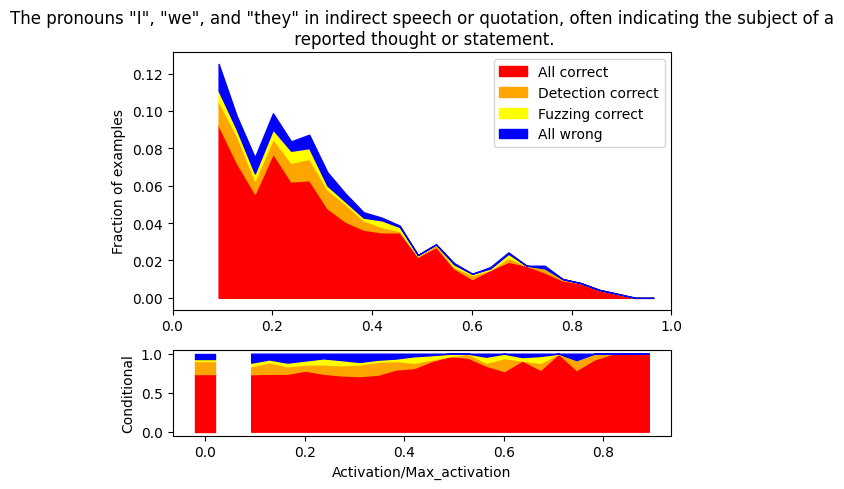

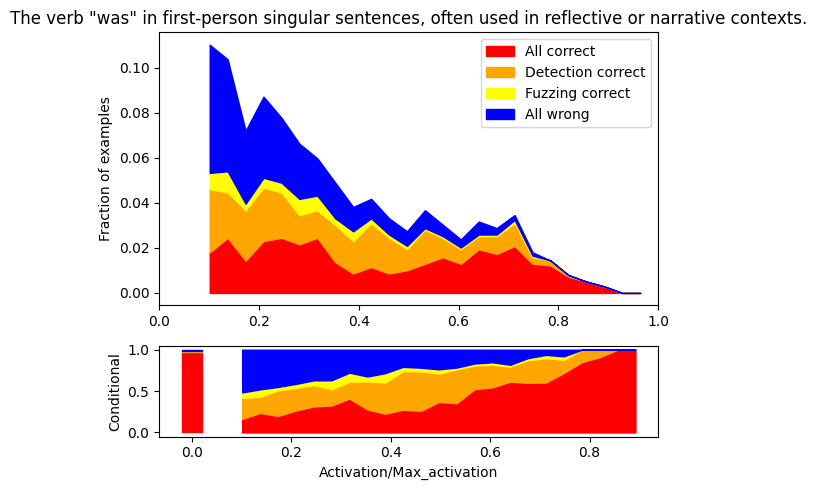

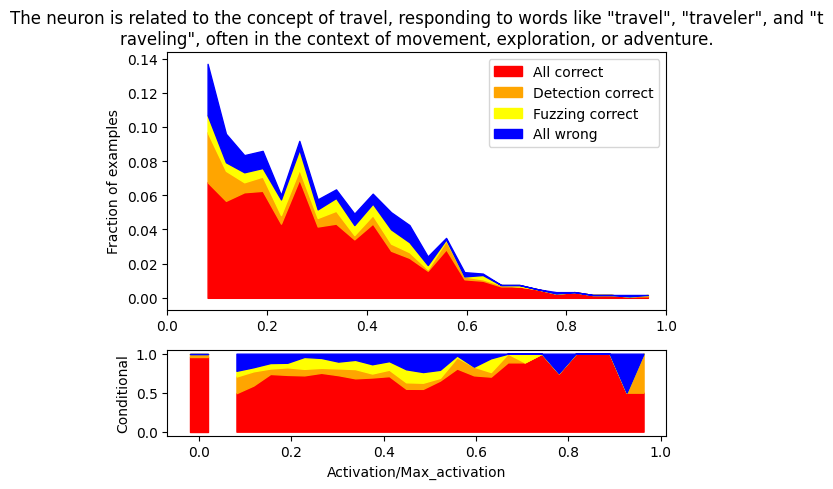

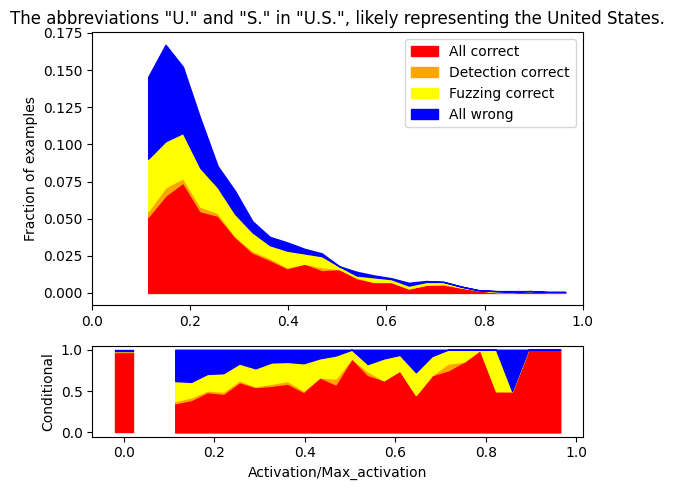

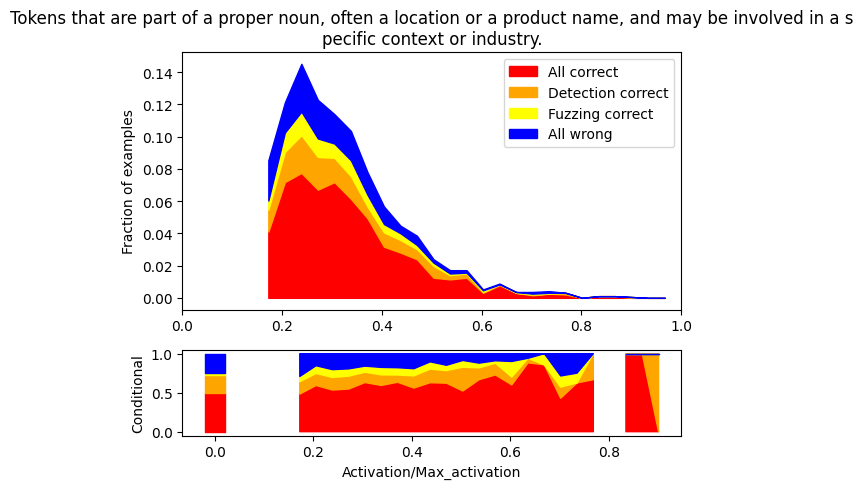

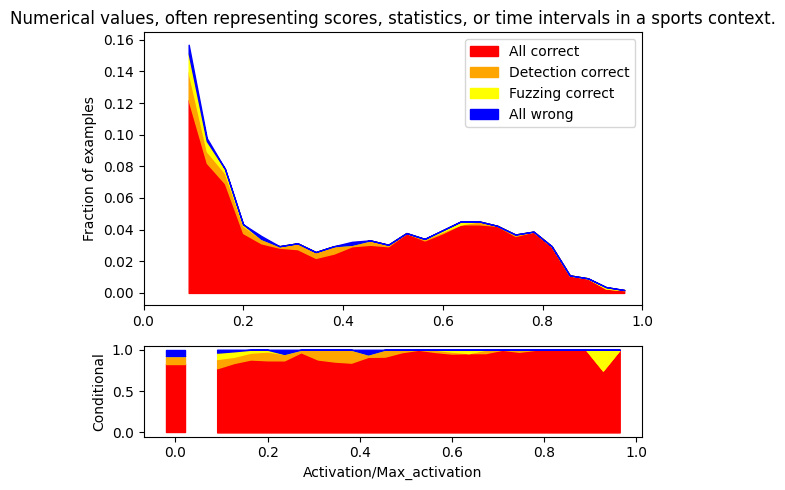

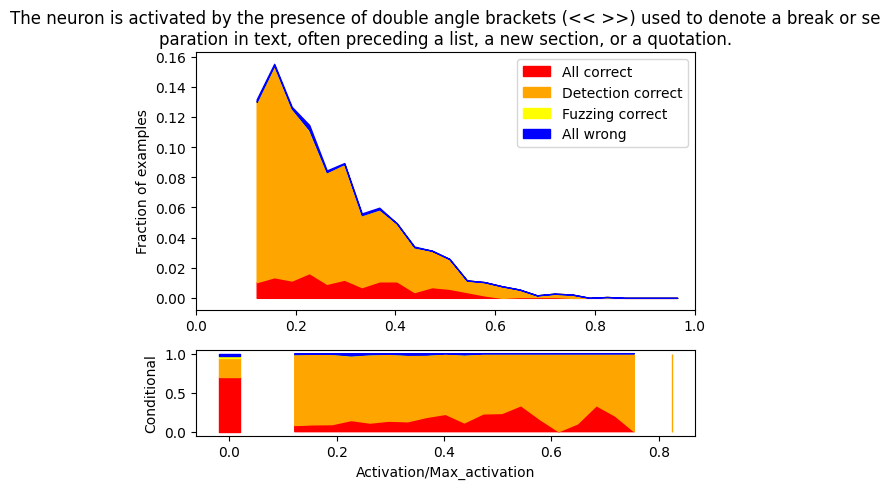

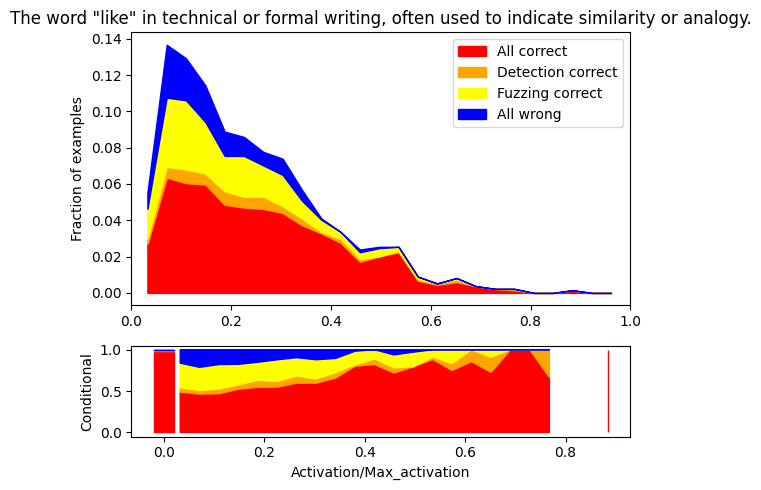

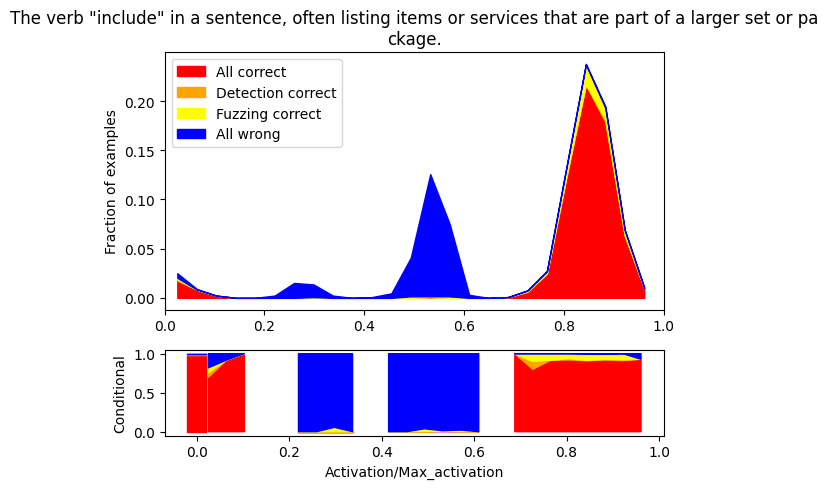

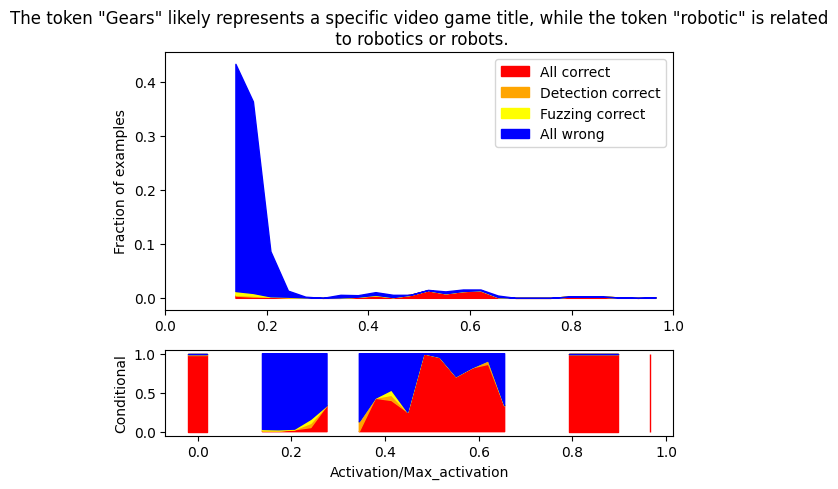

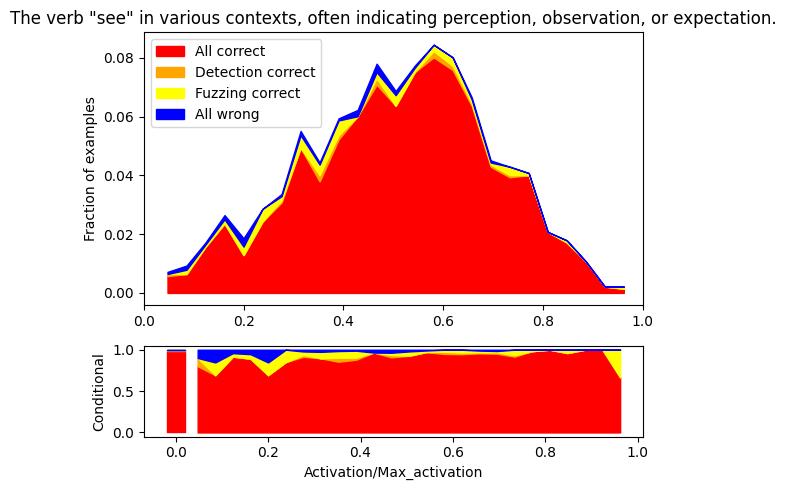

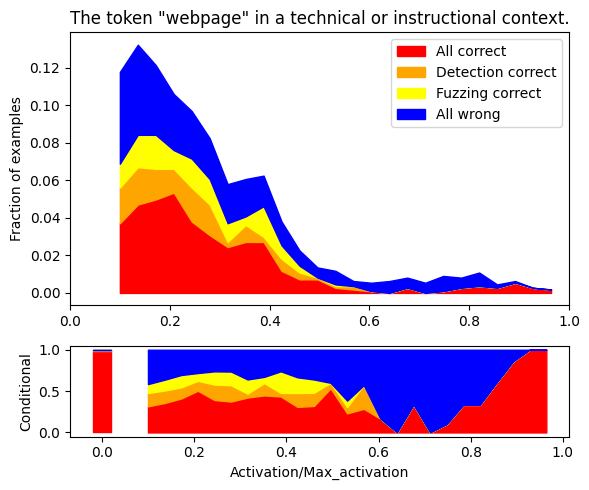

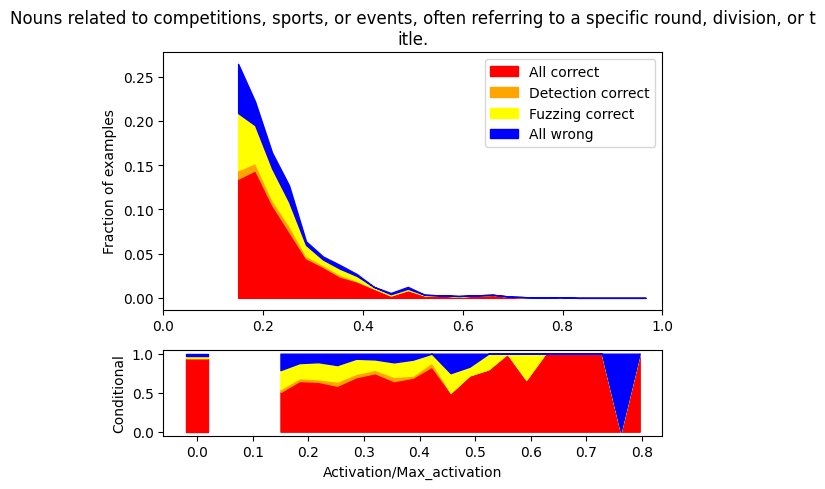

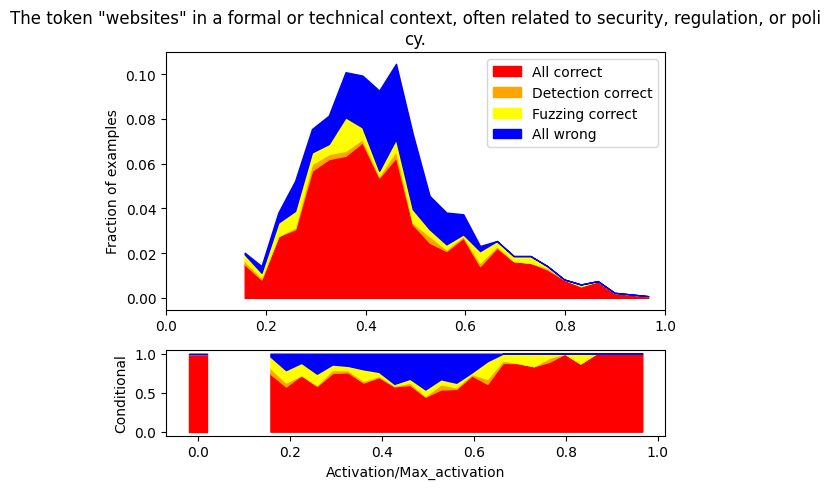

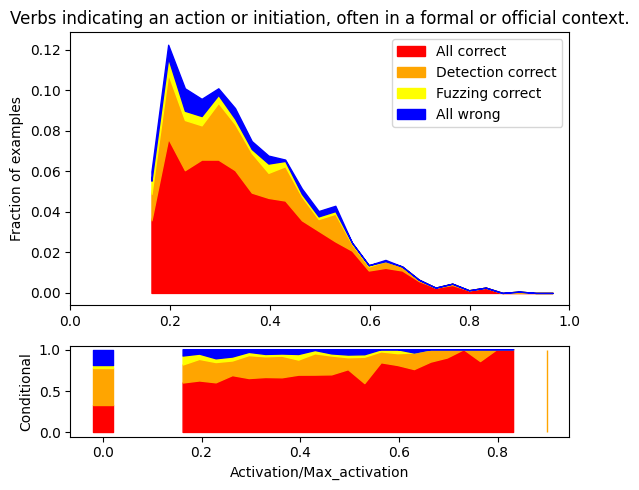

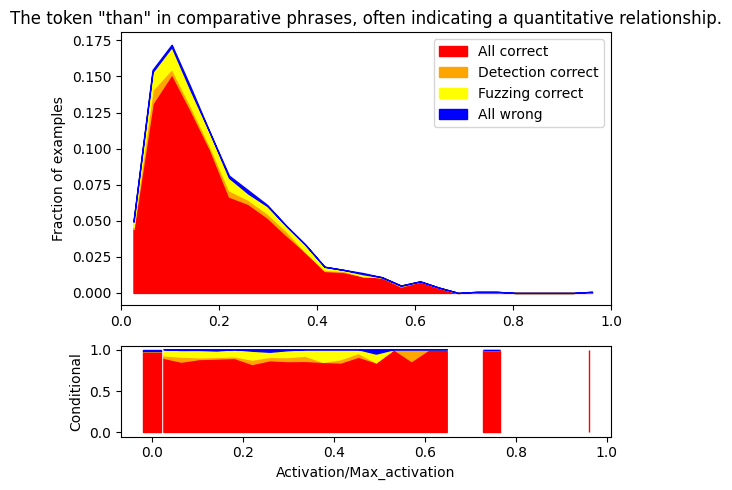

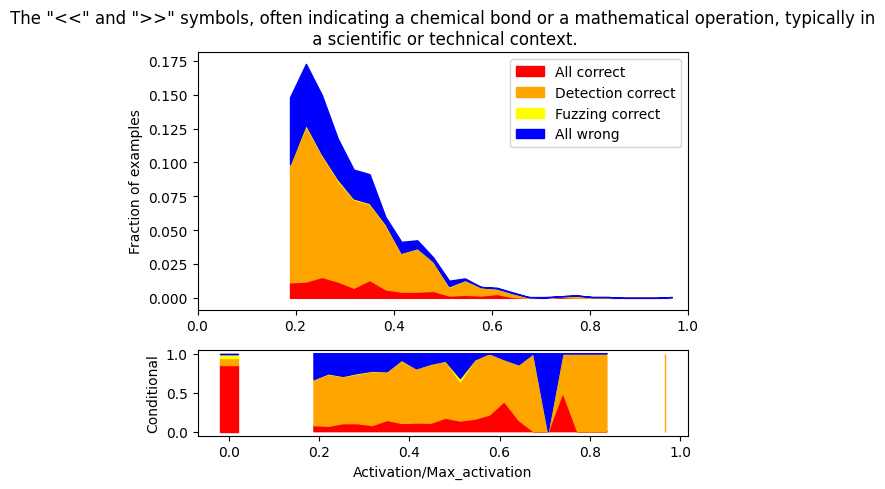

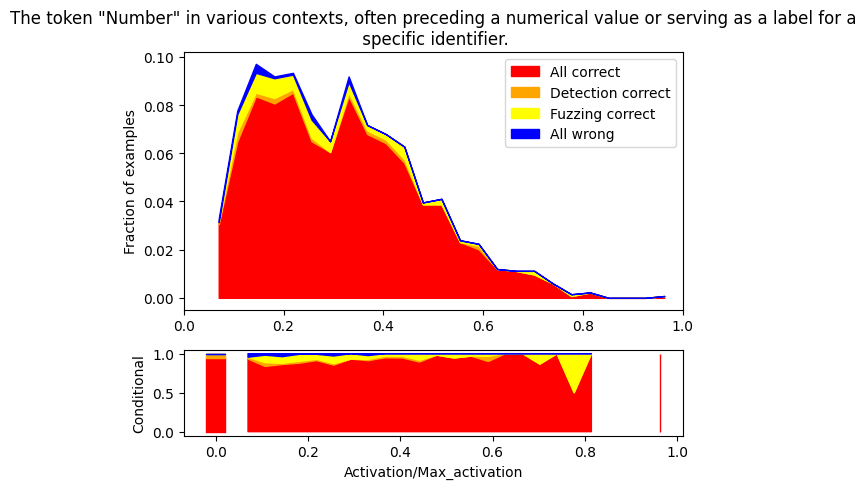

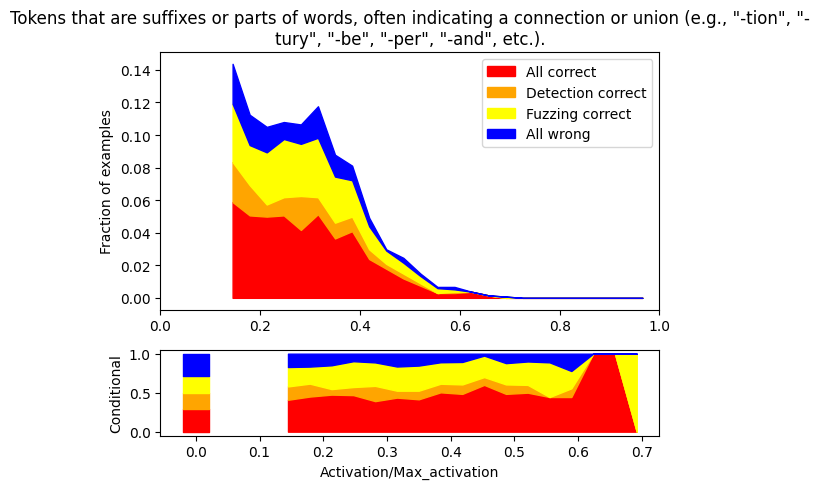

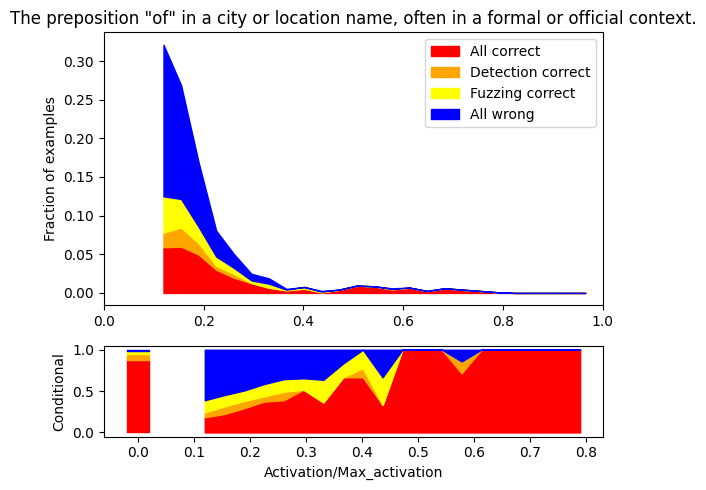

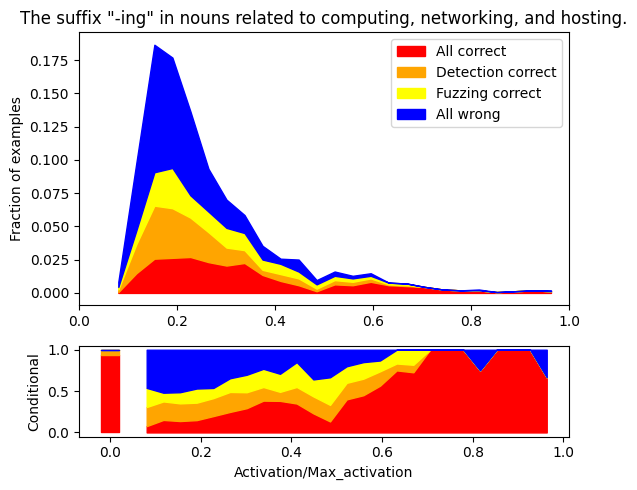

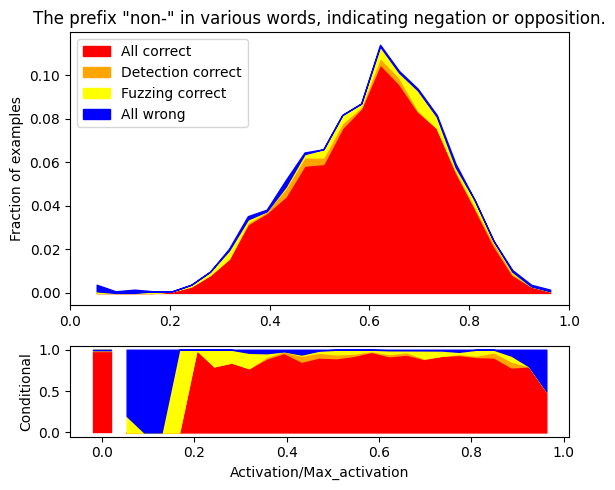

In [108]:
for i in range(22):
    anthropic_plot(i,"gpt2_top_10")

100%|██████████| 22/22 [00:00<00:00, 93.40it/s]


Doing: .transformer.h.2 39


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


[0.09239949 0.12870351 0.16500753 0.20131155 0.23761557 0.27391959
 0.31022361 0.34652763 0.38283166 0.41913568 0.4554397  0.49174372
 0.52804774 0.56435176 0.60065578 0.6369598  0.67326382 0.70956784
 0.74587186 0.78217588 0.8184799  0.85478392 0.89108794 0.92739196
 0.96369598 1.        ]
65 15 17 3


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 35


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


[0.10135163 0.13729756 0.1732435  0.20918943 0.24513537 0.2810813
 0.31702724 0.35297317 0.38891911 0.42486504 0.46081098 0.49675691
 0.53270285 0.56864878 0.60459472 0.64054065 0.67648659 0.71243252
 0.74837846 0.78432439 0.82027033 0.85621626 0.8921622  0.92810813
 0.96405407 1.        ]
97 0 3 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 20


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


[0.08081897 0.11758621 0.15435345 0.19112069 0.22788793 0.26465517
 0.30142241 0.33818966 0.3749569  0.41172414 0.44849138 0.48525862
 0.52202586 0.5587931  0.59556035 0.63232759 0.66909483 0.70586207
 0.74262931 0.77939655 0.81616379 0.85293103 0.88969828 0.92646552
 0.96323276 1.        ]
88 3 7 2


100%|██████████| 22/22 [00:00<00:00, 113.46it/s]


Doing: .transformer.h.2 24


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


[0.1139194  0.14936262 0.18480585 0.22024907 0.2556923  0.29113552
 0.32657874 0.36202197 0.39746519 0.43290842 0.46835164 0.50379486
 0.53923809 0.57468131 0.61012454 0.64556776 0.68101098 0.71645421
 0.75189743 0.78734066 0.82278388 0.8582271  0.89367033 0.92911355
 0.96455678 1.        ]
93 1 5 1


100%|██████████| 22/22 [00:00<00:00, 116.16it/s]


Doing: .transformer.h.1 34


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


[0.17249198 0.2055923  0.23869262 0.27179294 0.30489327 0.33799359
 0.37109391 0.40419423 0.43729455 0.47039487 0.50349519 0.53659551
 0.56969583 0.60279615 0.63589647 0.66899679 0.70209711 0.73519743
 0.76829776 0.80139808 0.8344984  0.86759872 0.90069904 0.93379936
 0.96689968 1.        ]
47 25 21 5


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 6


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


[0.0905315  0.12691024 0.16328898 0.19966772 0.23604646 0.2724252
 0.30880394 0.34518268 0.38156142 0.41794016 0.4543189  0.49069764
 0.52707638 0.56345512 0.59983386 0.6362126  0.67259134 0.70897008
 0.74534882 0.78172756 0.8181063  0.85448504 0.89086378 0.92724252
 0.96362126 1.        ]
75 7 18 0


100%|██████████| 22/22 [00:00<00:00, 116.38it/s]


Doing: .transformer.h.2 15


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


[0.12200285 0.15712274 0.19224263 0.22736251 0.2624824  0.29760228
 0.33272217 0.36784206 0.40296194 0.43808183 0.47320171 0.5083216
 0.54344148 0.57856137 0.61368126 0.64880114 0.68392103 0.71904091
 0.7541608  0.78928069 0.82440057 0.85952046 0.89464034 0.92976023
 0.96488011 1.        ]
45 13 41 1


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 0


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


[0.03209441 0.07081064 0.10952686 0.14824308 0.18695931 0.22567553
 0.26439175 0.30310798 0.3418242  0.38054042 0.41925665 0.45797287
 0.49668909 0.53540532 0.57412154 0.61283776 0.65155399 0.69027021
 0.72898644 0.76770266 0.80641888 0.84513511 0.88385133 0.92256755
 0.96128378 1.        ]
100 0 0 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 42


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


[0.02531847 0.06430573 0.10329299 0.14228025 0.18126751 0.22025478
 0.25924204 0.2982293  0.33721656 0.37620382 0.41519108 0.45417834
 0.4931656  0.53215287 0.57114013 0.61012739 0.64911465 0.68810191
 0.72708917 0.76607643 0.80506369 0.84405096 0.88303822 0.92202548
 0.96101274 1.        ]
92 2 6 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 26


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


[0.1380509  0.17252886 0.20700683 0.24148479 0.27596276 0.31044072
 0.34491868 0.37939665 0.41387461 0.44835258 0.48283054 0.5173085
 0.55178647 0.58626443 0.6207424  0.65522036 0.68969832 0.72417629
 0.75865425 0.79313222 0.82761018 0.86208814 0.89656611 0.93104407
 0.96552204 1.        ]
65 9 19 7


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 14


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


[0.04746264 0.08556414 0.12366563 0.16176713 0.19986862 0.23797011
 0.27607161 0.3141731  0.3522746  0.39037609 0.42847759 0.46657908
 0.50468057 0.54278207 0.58088356 0.61898506 0.65708655 0.69518805
 0.73328954 0.77139103 0.80949253 0.84759402 0.88569552 0.92379701
 0.96189851 1.        ]
97 1 0 0


100%|██████████| 22/22 [00:00<00:00, 116.53it/s]


Doing: .transformer.h.0 14


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


[0.09986107 0.13586663 0.17187218 0.20787774 0.2438833  0.27988886
 0.31589441 0.35189997 0.38790553 0.42391109 0.45991664 0.4959222
 0.53192776 0.56793331 0.60393887 0.63994443 0.67594999 0.71195554
 0.7479611  0.78396666 0.81997221 0.85597777 0.89198333 0.92798889
 0.96399444 1.        ]
98 1 1 0


100%|██████████| 22/22 [00:00<00:00, 98.19it/s] 


Doing: .transformer.h.2 5


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


[0.14979686 0.18380498 0.21781311 0.25182124 0.28582936 0.31983749
 0.35384561 0.38785374 0.42186186 0.45586999 0.48987812 0.52388624
 0.55789437 0.59190249 0.62591062 0.65991874 0.69392687 0.72793499
 0.76194312 0.79595125 0.82995937 0.8639675  0.89797562 0.93198375
 0.96599187 1.        ]
93 2 4 1


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 22


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


[0.15769471 0.19138692 0.22507914 0.25877135 0.29246356 0.32615577
 0.35984798 0.39354019 0.4272324  0.46092462 0.49461683 0.52830904
 0.56200125 0.59569346 0.62938567 0.66307788 0.6967701  0.73046231
 0.76415452 0.79784673 0.83153894 0.86523115 0.89892337 0.93261558
 0.96630779 1.        ]
99 0 1 0


100%|██████████| 22/22 [00:00<00:00, 94.67it/s]


Doing: .transformer.h.1 46


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


[0.16260818 0.19610385 0.22959952 0.2630952  0.29659087 0.33008654
 0.36358221 0.39707789 0.43057356 0.46406923 0.49756491 0.53106058
 0.56455625 0.59805192 0.6315476  0.66504327 0.69853894 0.73203462
 0.76553029 0.79902596 0.83252164 0.86601731 0.89951298 0.93300865
 0.96650433 1.        ]
29 20 45 6


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 26


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


[0.02565724 0.06463095 0.10360466 0.14257837 0.18155208 0.2205258
 0.25949951 0.29847322 0.33744693 0.37642064 0.41539435 0.45436806
 0.49334177 0.53231548 0.57128919 0.6102629  0.64923661 0.68821032
 0.72718403 0.76615774 0.80513145 0.84410516 0.88307887 0.92205258
 0.96102629 1.        ]
98 1 1 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.0 29


Loading features from tensor for layer .transformer.h.0: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


[0.18868449 0.22113711 0.25358973 0.28604235 0.31849497 0.35094759
 0.38340021 0.41585284 0.44830546 0.48075808 0.5132107  0.54566332
 0.57811594 0.61056856 0.64302118 0.6754738  0.70792642 0.74037904
 0.77283166 0.80528428 0.8377369  0.87018952 0.90264214 0.93509476
 0.96754738 1.        ]
68 3 14 15


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 12


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


[0.07004829 0.10724636 0.14444443 0.1816425  0.21884057 0.25603864
 0.2932367  0.33043477 0.36763284 0.40483091 0.44202898 0.47922705
 0.51642511 0.55362318 0.59082125 0.62801932 0.66521739 0.70241545
 0.73961352 0.77681159 0.81400966 0.85120773 0.8884058  0.92560386
 0.96280193 1.        ]
97 1 2 0


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 23


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


[0.14458914 0.17880558 0.21302201 0.24723844 0.28145488 0.31567131
 0.34988775 0.38410418 0.41832062 0.45253705 0.48675348 0.52096992
 0.55518635 0.58940279 0.62361922 0.65783566 0.69205209 0.72626853
 0.76048496 0.79470139 0.82891783 0.86313426 0.8973507  0.93156713
 0.96578357 1.        ]
30 38 27 5


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.1 38


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


[0.11957499 0.15479199 0.19000899 0.22522599 0.26044299 0.29565999
 0.33087699 0.36609399 0.40131099 0.43652799 0.47174499 0.50696199
 0.54217899 0.57739599 0.61261299 0.64782999 0.683047   0.718264
 0.753481   0.788698   0.823915   0.859132   0.894349   0.929566
 0.964783   1.        ]
7 52 37 4


/tmp/ipykernel_41409/3692147671.py:129: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],all_correct/normalization,0,color="red",label="All correct")
/tmp/ipykernel_41409/3692147671.py:130: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct))/normalization,all_correct/normalization,color="orange",label="Detection correct")
/tmp/ipykernel_41409/3692147671.py:131: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct))/normalization,(np.array(all_correct)+np.array(detection_correct))/normalization,color="yellow",label="Fuzzing correct")
/tmp/ipykernel_41409/3692147671.py:132: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(bins[:-1],(np.array(all_correct)+np.array(detection_correct)+np.array(fuzzing_correct)+np.array(all_wrong))/normalization,(np.array(all_c

Doing: .transformer.h.2 35


Loading features from tensor for layer .transformer.h.2: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


[0.08067673 0.11744967 0.1542226  0.19099553 0.22776846 0.26454139
 0.30131432 0.33808725 0.37486018 0.41163311 0.44840604 0.48517897
 0.5219519  0.55872483 0.59549776 0.63227069 0.66904362 0.70581656
 0.74258949 0.77936242 0.81613535 0.85290828 0.88968121 0.92645414
 0.96322707 1.        ]
30 20 48 2


/tmp/ipykernel_41409/3692147671.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,5))
100%|██████████| 22/22 [00:00<00:00, 98.75it/s] 


Doing: .transformer.h.1 47


Loading features from tensor for layer .transformer.h.1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


[0.0534435  0.09130576 0.12916802 0.16703028 0.20489254 0.2427548
 0.28061706 0.31847932 0.35634158 0.39420384 0.4320661  0.46992836
 0.50779062 0.54565288 0.58351514 0.6213774  0.65923966 0.69710192
 0.73496418 0.77282644 0.8106887  0.84855096 0.88641322 0.92427548
 0.96213774 1.        ]
99 0 1 0


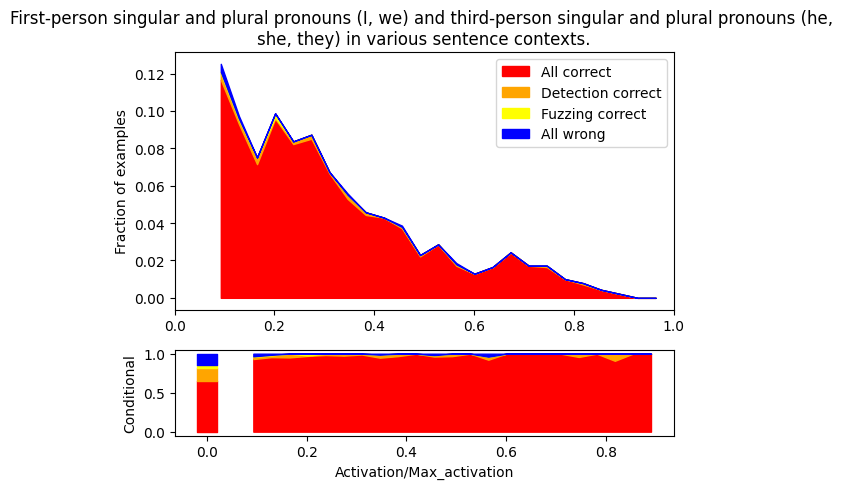

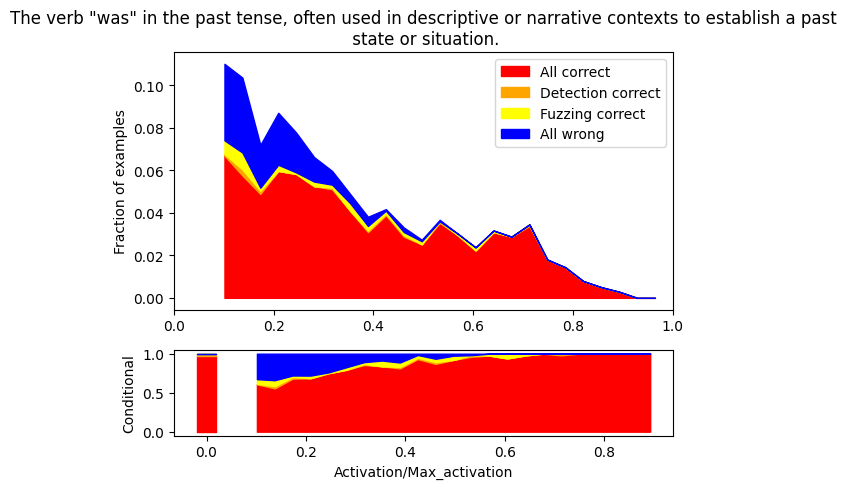

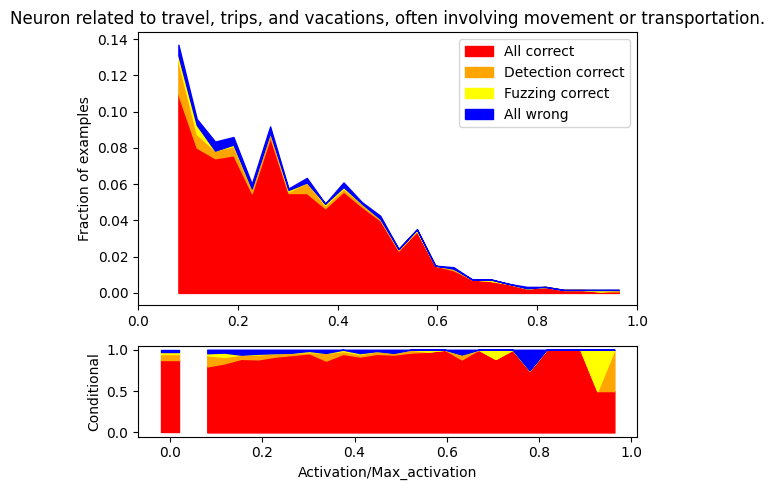

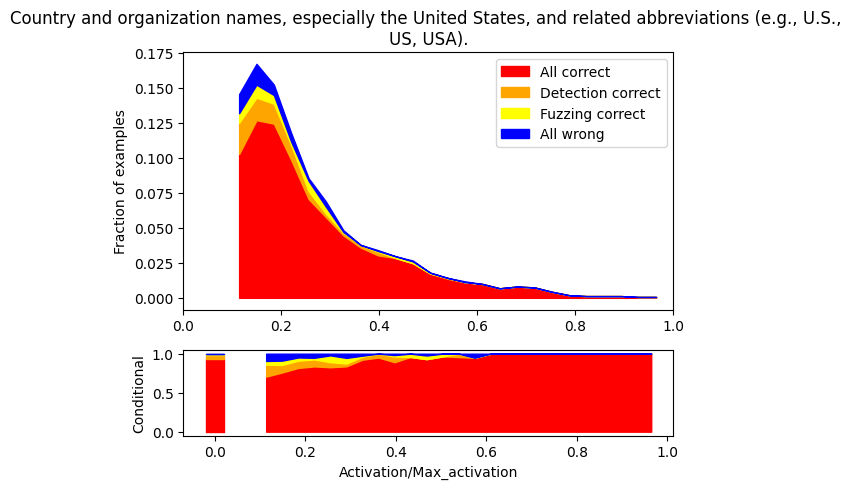

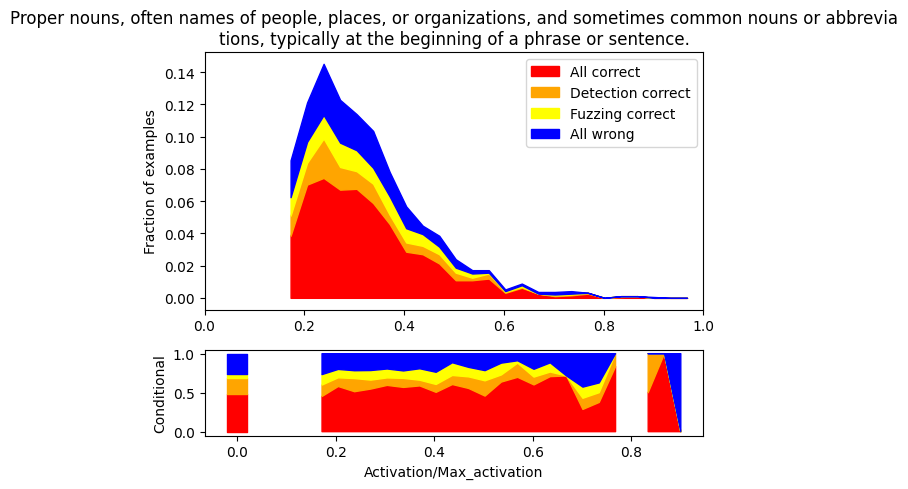

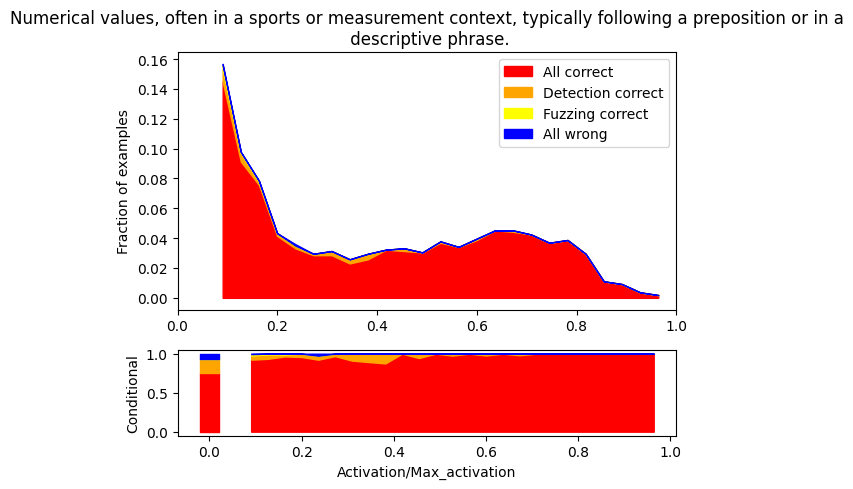

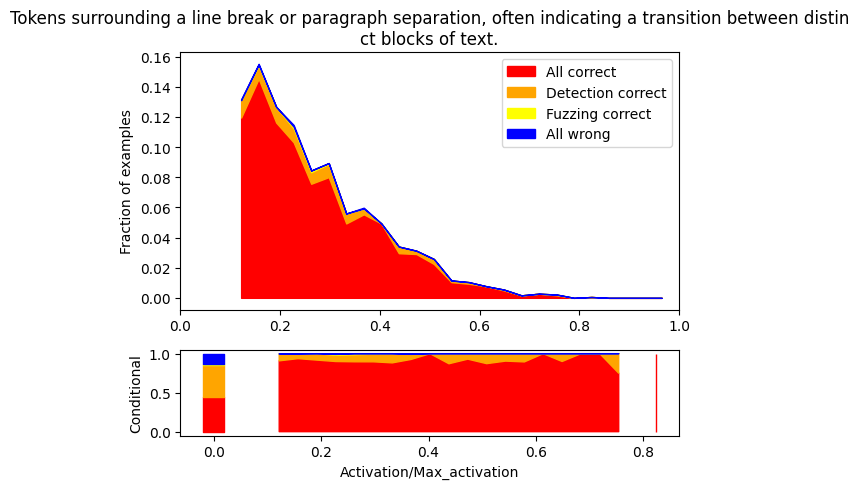

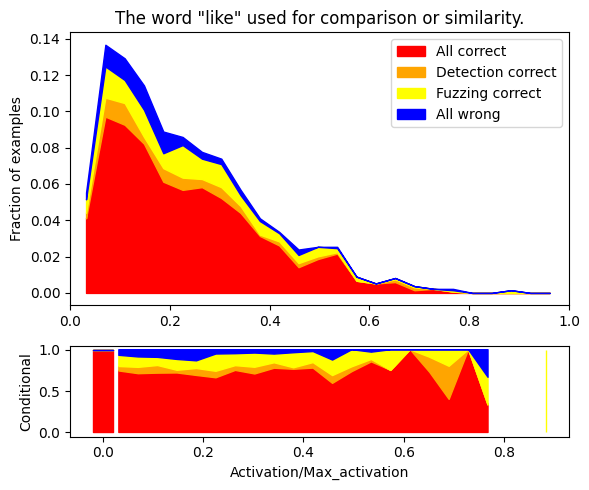

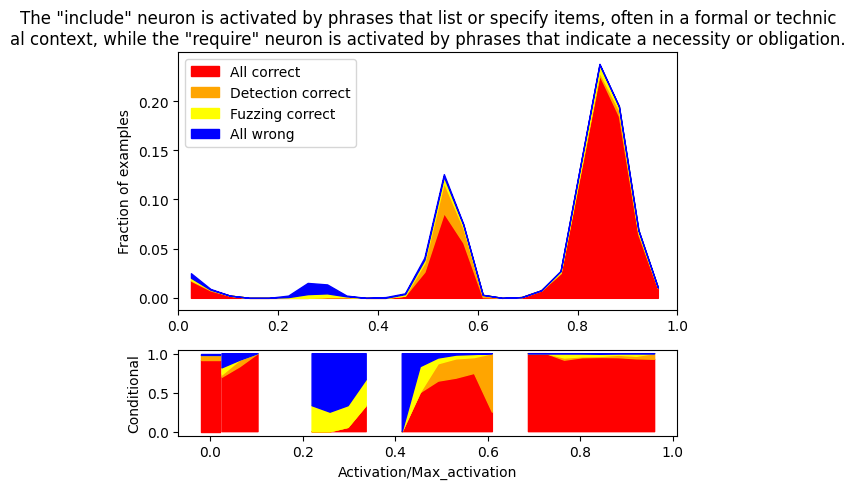

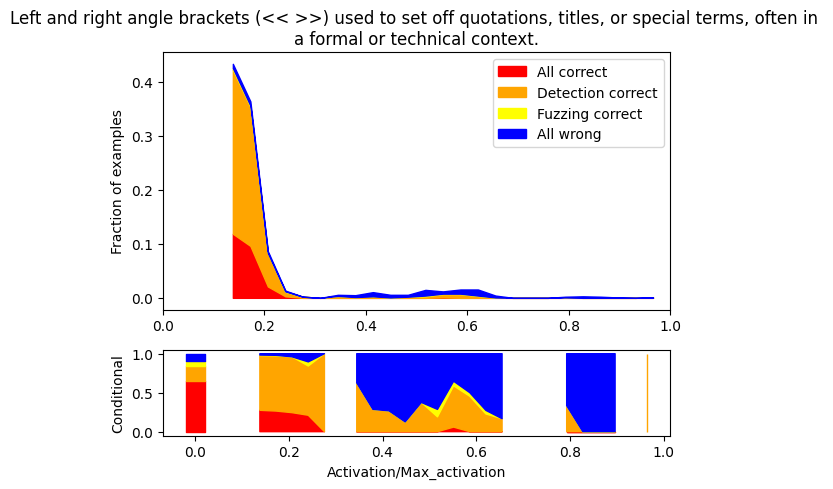

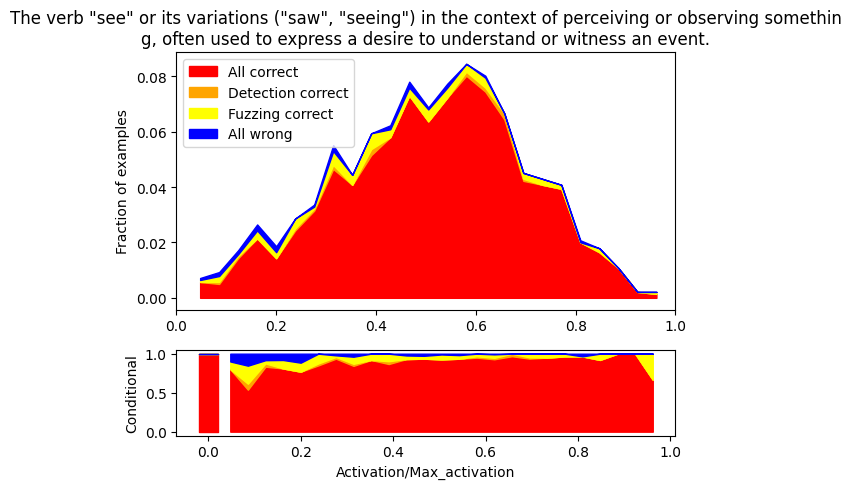

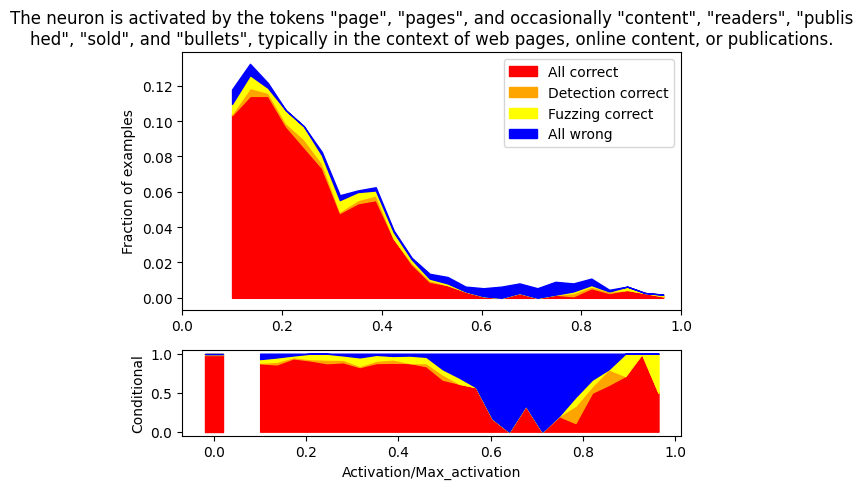

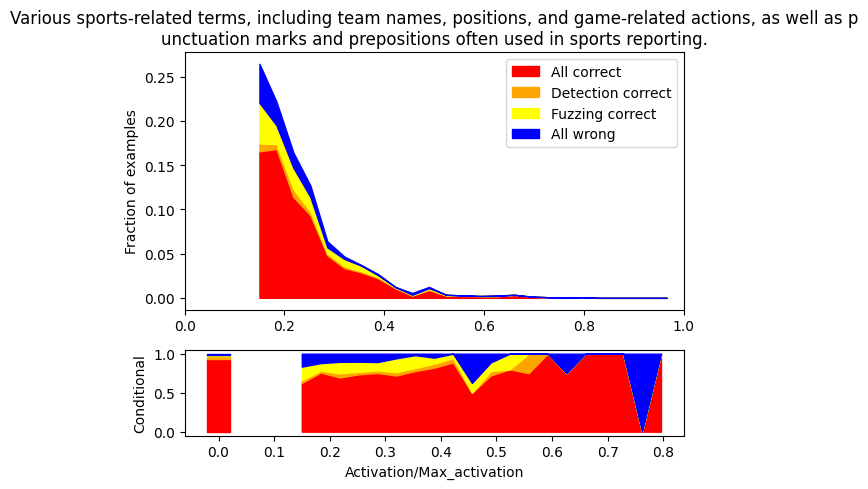

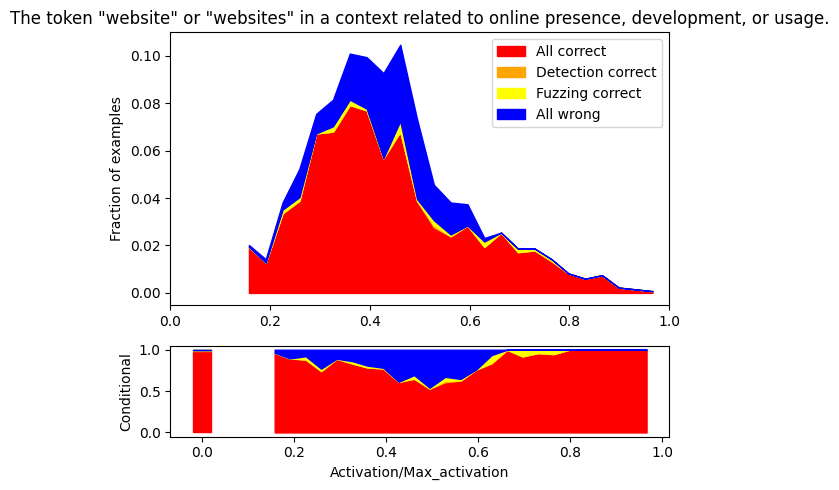

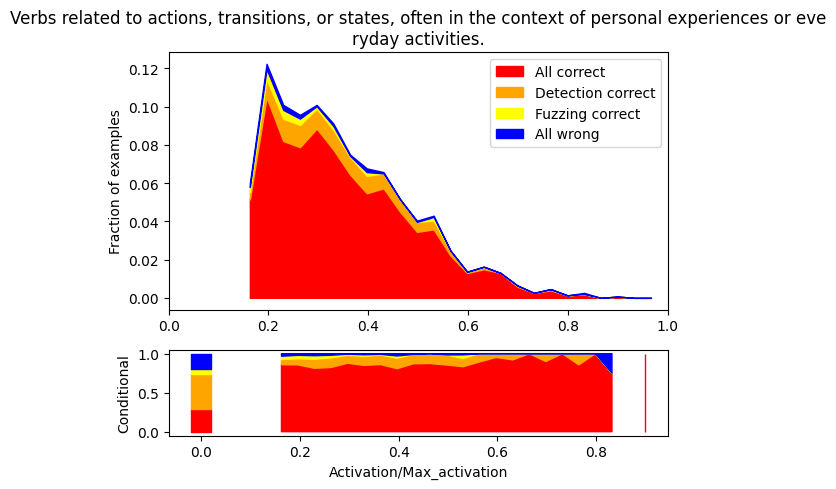

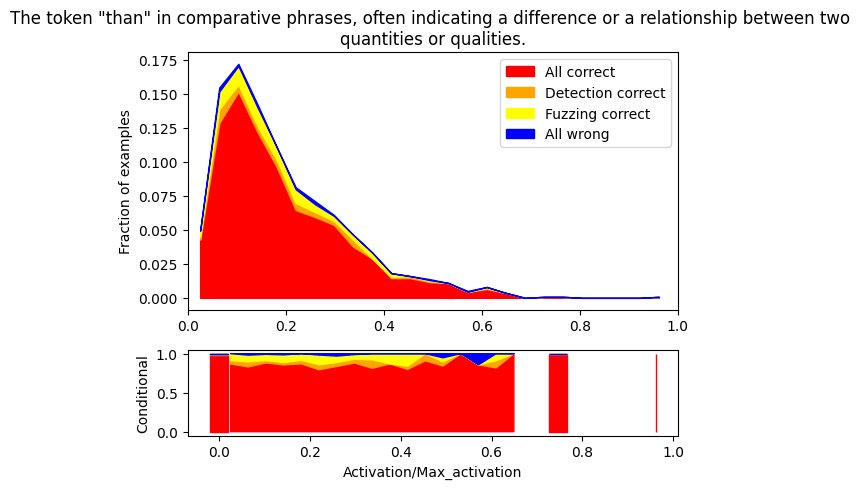

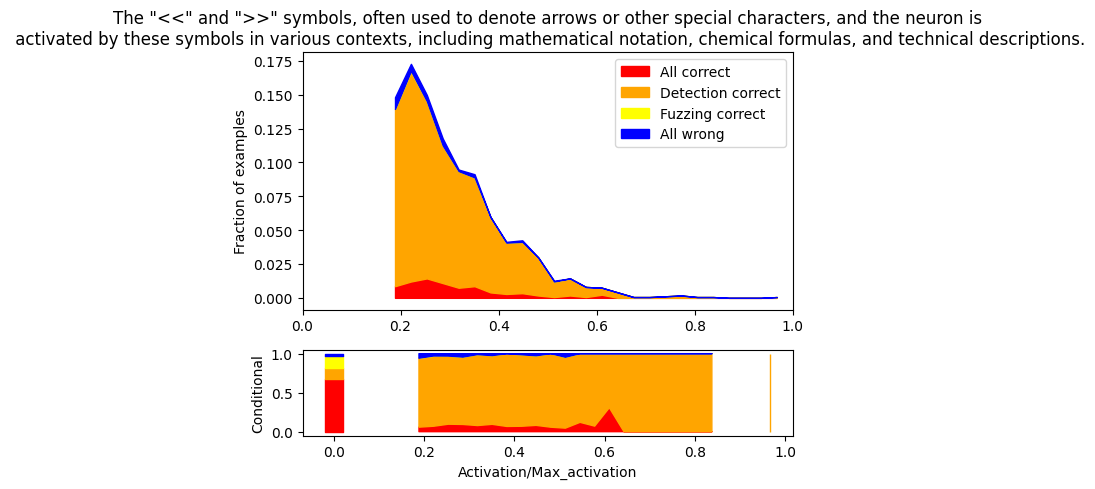

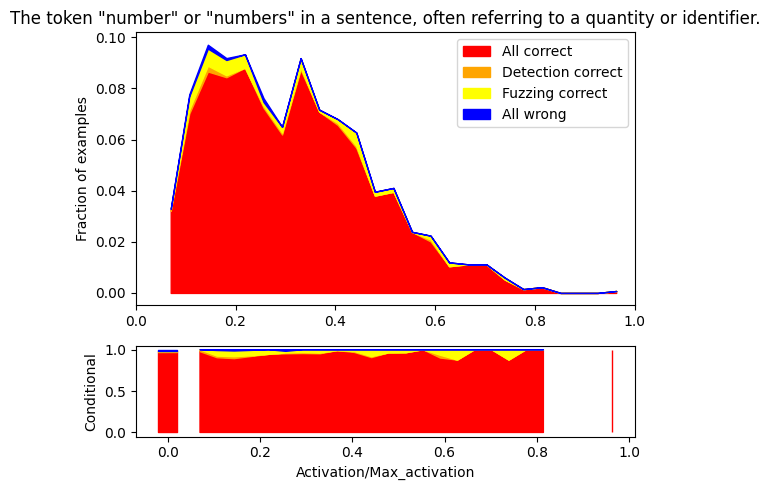

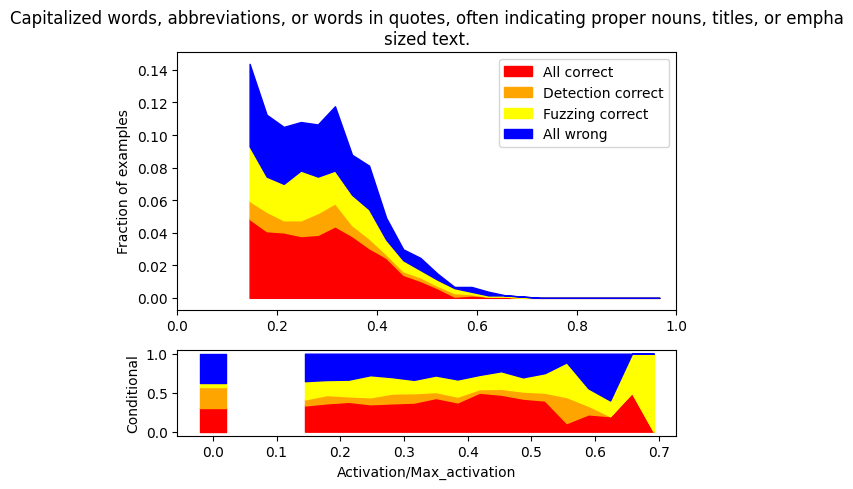

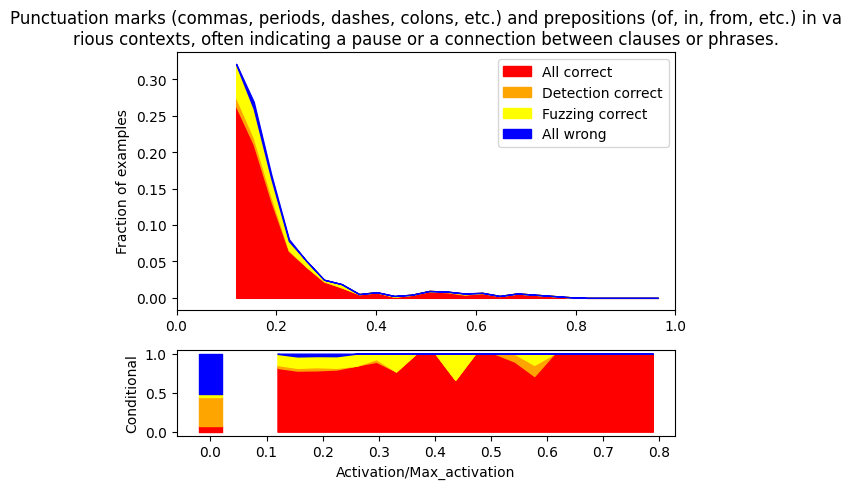

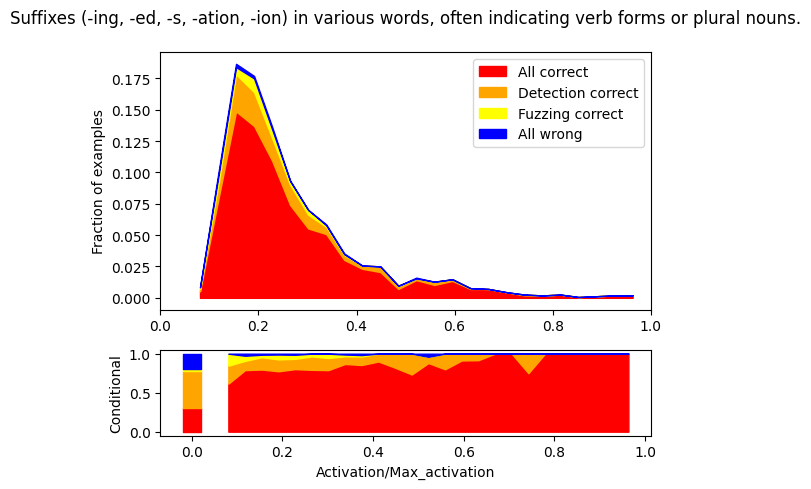

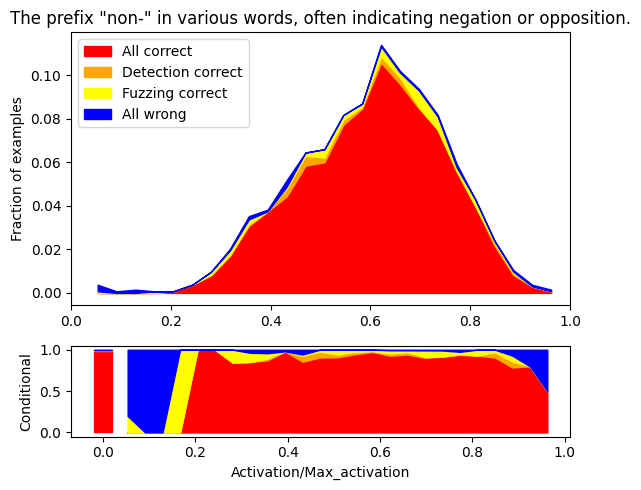

In [109]:
for i in range(22):
    anthropic_plot(i,"gpt2_random_40")

# Neighbour

In [33]:
def calculate_balanced_accuracy(dataframe):
    #True positive when data["activates"]==True and data["marked"]==True
    #False positive when data["activates"]==True and data["marked"]==False
    #True negative when data["activates"]==False and data["marked"]==False
    #False negative when data["activates"]==False and data["marked"]==True

    tp = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["prediction"]==True)])
    fp = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["prediction"]==True)])
    tn = len(dataframe[(dataframe["ground_truth"]==False) & (dataframe["prediction"]==False)])
    fn = len(dataframe[(dataframe["ground_truth"]==True) & (dataframe["prediction"]==False)])
    if tp+fn == 0:
        recall = np.nan
    else:
        recall = tp/(tp+fn)
    if tn+fp == 0:
        balanced_accuracy = np.nan
    else:
        balanced_accuracy = (recall+tn/(tn+fp))/2
    return balanced_accuracy

In [30]:
directory = "scores/gpt2_sim"
all_data={}
for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            ev_correlation_score = data["result"]["ev_correlation_score"]
            feature = filename.split(".txt")[0]
            if ev_correlation_score != "nan": 
                all_data[feature]=float(ev_correlation_score)
            else:
                all_data[feature]=0
sim_dataframe = pd.DataFrame(all_data.items(),columns=["feature","ev_correlation_score"])
                

100%|██████████| 352/352 [00:00<00:00, 6150.29it/s]


In [34]:
directory = "scores/gpt2_neighbours"
all_data = []
counter = 0
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
        for d in data:
            #d.pop('text')
            feature = filename.split(".txt")[0]
            d["feature"]=feature
        #remove from the data the points where predicted == -1
        data = [d for d in data if d["predicted"] != -1]
        
        all_data.extend(data)
        
data_df = pd.DataFrame(all_data)
data_df["correct"]=data_df["ground_truth"]==data_df["prediction"]
features = data_df["feature"].unique()
detector_scores = {i:0 for i in features}
for i in features:
    individual_scores = data_df[data_df["feature"]==i]
    detector_scores[i] = calculate_balanced_accuracy(individual_scores)
   

100%|██████████| 193/193 [00:00<00:00, 9911.48it/s]


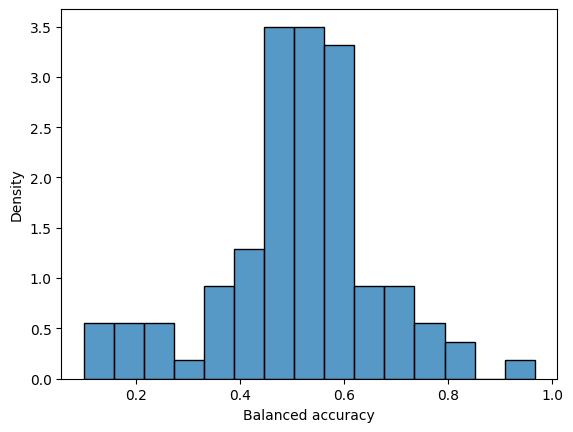

In [68]:
sns.histplot(detector_scores,stat="density")
plt.ylabel("Density")
plt.xlabel("Balanced accuracy")
plt.savefig("detector_neighbor_scores.svg")

In [37]:
bars,bins = np.histogram(data_df["distance"], bins=20)

In [38]:
correct = []
incorrect = []
#iterate over data_df
for index, row in data_df.iterrows():
    if row["correct"]:
        correct.append(row["distance"])
    else:
        incorrect.append(row["distance"])

In [39]:
correct_bars,_ = np.histogram(correct,bins=bins)
incorrect_bars,_ = np.histogram(incorrect,bins=bins)


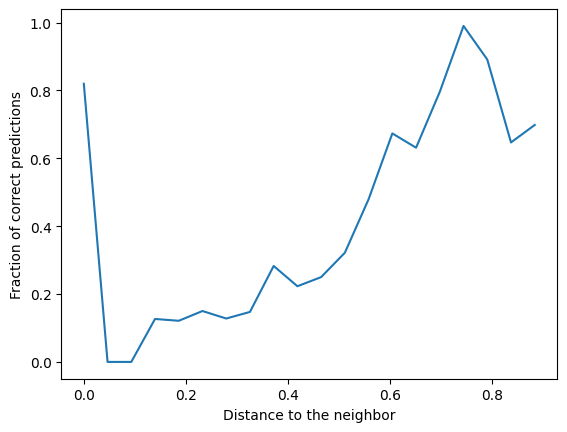

In [41]:
plt.plot(bins[:-1],correct_bars/(correct_bars+incorrect_bars+0.1))
plt.ylabel("Fraction of correct predictions")
plt.xlabel("Distance to the neighbor")
plt.savefig("correct_neighbor_scores.svg")

In [107]:
new_accuracy = pd.DataFrame(detector_scores.items(),columns=["feature","balanced_accuracy"])

In [108]:
merged = pd.merge(new_accuracy, sim_dataframe, on="feature")


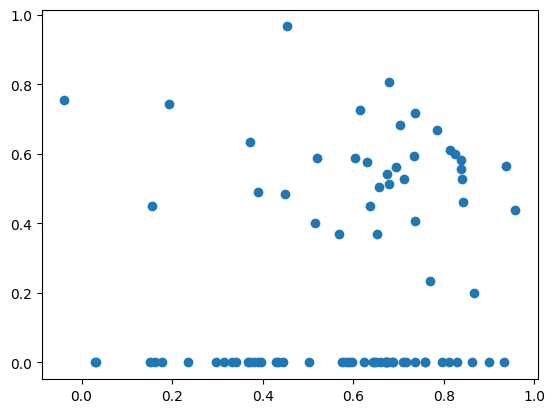

In [109]:
plt.scatter(merged["ev_correlation_score"],merged["balanced_accuracy"])